# PRÁCTICA FINAL ML PROBLEMA DE REGRESIÓN AIRBNB
* El siguiente notebook pone en práctica todo lo aprendido en la asignatura de Machine Learning Modelos Supervisados y ha sido realizada por Alvaro Oliva, Luis Iglesias y Jaime Pulido.

##### Airbnb es una compañía que ofrece una plataforma digital dedicada a la oferta de alojamientos a particulares y turísticos mediante la cual los anfitriones pueden publicitar y contratar el arriendo de sus propiedades con sus huéspedes; anfitriones y huéspedes pueden valorarse mutuamente, como referencia para futuros usuarios. Airbnb tiene una oferta de unas 2 000 000 propiedades en 192 países y 33 000 ciudades. Desde su creación en noviembre de 2008 hasta junio de 2012 se realizaron 10 millones de reservas.
##### El objetivo de esta práctica es realizar un evaluador automático de precios a partir de las características de los alojamientos

# Link GitHub Jaime Pulido

## 1. LIBRERÍAS A UTILIZAR
* Para este trabajo se utilizaran las siguientes librerías: 
  - Pandas: : 
  - langdetect: para detectar el idioma de la columna notes

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import re
from langdetect import detect
from datetime import datetime
from sklearn.impute import KNNImputer
from textblob import TextBlob
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.cluster import KMeans

from matplotlib.colors import ListedColormap
%matplotlib inline

import scipy.stats as ss

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

## 2. CARGA DE DATOS
* Se utiliza el dataset airbnb_listings_extract, el cual está formado por 14780 alojamientos teniendo un total de 86 características para cada uno de ellos

In [2]:
df = pd.read_csv('airbnb_listings_extract.csv', sep = ";")
df.columns = df.columns.str.lower()
df = df.rename(columns=lambda x: x.replace(' ', '_'))
print(df.shape)
df.head()

(14780, 89)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_communication,review_scores_location,review_scores_value,license,jurisdiction_names,cancellation_policy,calculated_host_listings_count,reviews_per_month,geolocation,features
0,11210388,https://www.airbnb.com/rooms/11210388,20170306202425,2017-03-07,The Loft-Full Bath-Deck w/View,Loft in the Hill country 12-15 minutes directl...,This loft has a spectacular view of the hills ...,Loft in the Hill country 12-15 minutes directl...,none,This neighborhood is located in the hills west...,...,10.0,10.0,10.0,NaN,NaN,moderate,1.0,3.50,"30.3373609355,-97.8632766782","Host Is Superhost,Host Has Profile Pic,Host Id..."
1,17471131,https://www.airbnb.com/rooms/17471131,20170407214050,2017-04-08,"Claris I, Friendly Rentals","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...",none,Plaza Cataluña Catalonia Square is the large...,...,10.0,8.0,10.0,HUTB-006721,NaN,super_strict_30,106.0,0.86,"41.3896829422,2.17262543017","Host Has Profile Pic,Requires License,Instant ..."
2,17584891,https://www.airbnb.com/rooms/17584891,20170407214050,2017-04-08,"Style Terrace Red, Friendly Rentals","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...",none,Plaza Cataluña Catalonia Square is the large...,...,NaN,NaN,NaN,HUTB-007527,NaN,super_strict_30,106.0,NaN,"41.3930345489,2.16217327868","Host Has Profile Pic,Requires License,Instant ..."
3,5398030,https://www.airbnb.com/rooms/5398030,20170407214050,2017-04-08,Picasso Suite 1.4 Paseo de Gracia,Live like a local in Barcelona's most chic dis...,You wake up to the sun rising over Barcelona's...,Live like a local in Barcelona's most chic dis...,none,We're right in the heart of the chic L'Eixampl...,...,10.0,10.0,9.0,NaN,NaN,strict,24.0,1.09,"41.3969668101,2.1674178103","Host Has Profile Pic,Host Identity Verified,Re..."
4,18104606,https://www.airbnb.com/rooms/18104606,20170407214050,2017-04-08,Smart City Centre Apartment II,"Unique apartment in vibrant neighborhoods, car...","License: HUTB-005313 Charming apartment, locat...","Unique apartment in vibrant neighborhoods, car...",none,NaN,...,NaN,NaN,NaN,NaN,NaN,flexible,92.0,NaN,"41.3886851936,2.15514963616","Host Has Profile Pic,Host Identity Verified,Is..."


In [3]:
# Primera aproximación de los datos
def get_dataset_statistics(df):
    num_variables = len(df.columns)
    num_observations = len(df)
    missing_cells = df.isnull().sum().sum()
    missing_cells_percentage = (missing_cells / (df.shape[0] * df.shape[1])) * 100
    duplicate_rows = df.duplicated().sum()
    duplicate_rows_percentage = (duplicate_rows / df.shape[0]) * 100
    
    table = pd.DataFrame({
        'Statistic': ['Number of variables', 'Number of observations', 'Missing cells', 'Missing cells (%)', 'Duplicate rows', 'Duplicate rows (%)'],
        'Value': [num_variables, num_observations, missing_cells, f'{missing_cells_percentage:.1f}%', duplicate_rows, f'{duplicate_rows_percentage:.1f}%']
    })
    
    return table

get_dataset_statistics(df)

,Statistic,Value
0,Number of variables,89
1,Number of observations,14780
2,Missing cells,214382
3,Missing cells (%),16.3%
4,Duplicate rows,0
5,Duplicate rows (%),0.0%


## 3. ANÁLISIS DESCRIPTIVO Y EVALUACIÓN DE DATOS MISSING

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14780 entries, 0 to 14779
Data columns (total 89 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14780 non-null  int64  
 1   listing_url                     14780 non-null  object 
 2   scrape_id                       14780 non-null  int64  
 3   last_scraped                    14780 non-null  object 
 4   name                            14779 non-null  object 
 5   summary                         14189 non-null  object 
 6   space                           10888 non-null  object 
 7   description                     14774 non-null  object 
 8   experiences_offered             14780 non-null  object 
 9   neighborhood_overview           9134 non-null   object 
 10  notes                           5644 non-null   object 
 11  transit                         9066 non-null   object 
 12  access                          

In [5]:
# Se hace uso de la funcion describe que da una primera visión de los datos (media, mediana, quantiles, mínimo, máximo, etc) de las columnas cuantitativas 
df.describe()

,id,scrape_id,host_id,host_response_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
count,1.478000e+04,1.478000e+04,1.478000e+04,12881.000000,14777.000000,14777.000000,14780.000000,14780.000000,14780.000000,14725.000000,...,14780.000000,11476.000000,11454.000000,11460.000000,11443.000000,11460.000000,11440.000000,11439.000000,14776.000000,11618.000000
mean,1.028089e+07,2.017037e+13,3.608080e+07,94.823461,12.513636,12.513636,40.497626,-3.858041,3.277808,1.281732,...,22.632273,91.697978,9.416012,9.328883,9.621778,9.647033,9.532168,9.218201,9.486871,1.870014
std,5.564829e+06,5.667971e+08,3.425360e+07,15.215988,34.090223,34.090223,4.641387,14.123146,2.097291,0.658517,...,38.290244,8.989101,0.921938,0.989933,0.802736,0.767116,0.774527,0.950578,23.626014,1.867550
min,1.862800e+04,2.016010e+13,1.745300e+04,0.000000,0.000000,0.000000,-37.851182,-123.131344,1.000000,0.000000,...,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.020000
25%,5.554732e+06,2.017041e+13,6.787360e+06,100.000000,1.000000,1.000000,40.409726,-3.707604,2.000000,1.000000,...,1.000000,89.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,1.000000,0.450000
50%,1.133492e+07,2.017041e+13,2.464875e+07,100.000000,2.000000,2.000000,40.419466,-3.700785,3.000000,1.000000,...,7.000000,94.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,2.000000,1.200000
75%,1.532631e+07,2.017041e+13,5.432919e+07,100.000000,6.000000,6.000000,40.430916,-3.684057,4.000000,1.000000,...,27.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,5.000000,2.780000
max,1.910969e+07,2.017062e+13,1.247534e+08,100.000000,519.000000,519.000000,55.966912,153.371427,16.000000,8.000000,...,446.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,145.000000,17.210000


In [6]:
#Cantidad de valores nulos.

#Creamos una tabla en la que sí  el dato es NA nos devuelve True, si no, False
missing_data = df.isnull() 
missing_data.head(5)
#Contamos cuantos True existen en la tabla, es decir, contamos cuantos valores missing existen en la tabla
true_counts = [(column, np.count_nonzero(missing_data[column] == True)) for column in missing_data.columns]
true_counts

[('id', 0),
 ('listing_url', 0),
 ('scrape_id', 0),
 ('last_scraped', 0),
 ('name', 1),
 ('summary', 591),
 ('space', 3892),
 ('description', 6),
 ('experiences_offered', 0),
 ('neighborhood_overview', 5646),
 ('notes', 9136),
 ('transit', 5714),
 ('access', 6462),
 ('interaction', 6552),
 ('house_rules', 5161),
 ('thumbnail_url', 2820),
 ('medium_url', 2820),
 ('picture_url', 19),
 ('xl_picture_url', 2820),
 ('host_id', 0),
 ('host_url', 0),
 ('host_name', 3),
 ('host_since', 3),
 ('host_location', 43),
 ('host_about', 5241),
 ('host_response_time', 1899),
 ('host_response_rate', 1899),
 ('host_acceptance_rate', 14741),
 ('host_thumbnail_url', 3),
 ('host_picture_url', 3),
 ('host_neighbourhood', 3876),
 ('host_listings_count', 3),
 ('host_total_listings_count', 3),
 ('host_verifications', 6),
 ('street', 0),
 ('neighbourhood', 5229),
 ('neighbourhood_cleansed', 0),
 ('neighbourhood_group_cleansed', 1020),
 ('city', 6),
 ('state', 144),
 ('zipcode', 506),
 ('market', 57),
 ('smart_loc

In [7]:
# Ratio de nulos por columna
df_num_na_ratio = (df.isnull().sum() / len(df) * 100).sort_values(ascending = False)
df_num_na_ratio.head(20)

has_availability         99.918809
host_acceptance_rate     99.736130
jurisdiction_names       98.464141
license                  97.638701
square_feet              95.953992
monthly_price            75.906631
weekly_price             75.710419
notes                    61.813261
security_deposit         57.672530
interaction              44.330176
access                   43.721245
cleaning_fee             41.224628
transit                  38.660352
neighborhood_overview    38.200271
host_about               35.460081
neighbourhood            35.378890
house_rules              34.918809
space                    26.332882
host_neighbourhood       26.224628
review_scores_value      22.604871
dtype: float64

In [8]:
# Se eliminan las columnas con más de un 90% de valores nulos
df.drop(['has_availability', 'host_acceptance_rate', 'jurisdiction_names', 'license', 'square_feet'], axis = 1, inplace = True)

In [9]:
# Se eliminan columnas que no aportan información al modelo predictivo
not_useful_columns = [
    'id', 'listing_url', 'scrape_id', 'last_scraped', 'thumbnail_url', 'medium_url', 
    'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'name',
    'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'calendar_last_scraped', 
    'host_location', 'host_verifications', 'interaction', 'notes',
    'neighborhood_overview', 'access', 'transit', 
    'street', 'neighbourhood_cleansed', 'zipcode', 'smart_location', 'city'
]
df = df.reset_index()
df.drop(not_useful_columns, axis = 1, inplace = True)

In [10]:
## Sustituir el valor nulo de estas columnas por 0
sustituir_por_0 = ['security_deposit', 'cleaning_fee', 'bedrooms', 'bathrooms', 'beds', 'reviews_per_month', 'calculated_host_listings_count', 'host_listings_count', 'host_total_listings_count']
df.loc[:, sustituir_por_0] = df.loc[:, sustituir_por_0].fillna(0)

In [11]:
## Sustituir el valor nulo de estas columnas por -99
sustituir_por_99 = ['monthly_price', 'weekly_price']
df.loc[:, sustituir_por_99] = df.loc[:, sustituir_por_99].fillna(-99)

In [12]:
## Reemplazar los valores del tiempo de respuesta del propietario del alojamiento por escala numerica
reemplazo = {'within an hour': 1, 'within a few hours': 12, 'within a day': 24, 'a few days or more': 72}
df['host_response_time'] = df['host_response_time'].replace(reemplazo).fillna(99)

In [13]:
## Se utiliza la libreria textblob para el anañisis de sentimiento de texto que mide la polaridad. 
##  La polaridad varía entre -1 y 1, donde -1 indica una opinión muy negativa y 1 indica una opinión muy positiva.

def sentiment_polarity(text):
    try:
        blob = TextBlob(text).sentiment.polarity
        return blob
    except: 
        pass

columns_polarity = ["summary", "house_rules", "features", "space", "host_about", "description"]

for i in columns_polarity: 
    df[i+'_polarity'] = df[i].apply(lambda x: sentiment_polarity(x)).fillna(99)

df.drop(columns_polarity, axis = 1, inplace = True)

In [14]:
#Se utiliza la funcion de split_geolocalization para obtener los valores de la longitud y la latitud
def split_geolocalization(df):
    # Divide la columna "geolocalization" en dos columnas separadas por la coma
    df[['latitud', 'longitud']] = df['geolocation'].str.split(',', expand=True)
    
    # Convierte las columnas "latitud" y "longitud" al tipo de dato numérico
    df['latitud'] = pd.to_numeric(df['latitud'])
    df['longitud'] = pd.to_numeric(df['longitud'])
    
    # Devuelve el DataFrame actualizado
    return df

df = split_geolocalization(df)
df.drop(['geolocation'], axis = 1, inplace = True)

In [15]:
# La columna calendar_updated que es categorica se convierte a float utilizando la siguiente funcion
def convert_to_days(value):
    try: 
        if value == 'today':
            return 0
        elif value == 'yesterday':
            return 1
        elif value == 'never':
            return None
        else:
            num = int(re.search(r'\d+', value).group())
            if 'day' in value:
                return num
            elif 'week' in value:
                return num * 7
            elif 'month' in value:
                return num * 30
    
    except: 
        return 0

# Convertimos los valores en días
df['calendar_updated'] = df['calendar_updated'].apply(convert_to_days)
df['calendar_updated'] = df['calendar_updated'].fillna(0)

In [16]:
## Para la columna amenity se utiliza esta funcion que puntua del 1 al 10 en importancia para el precio de la habitacion
## La importancia numérica la hemos basado en la posible relación que cada elemento puede tener para incrementar su precio
def score_amenities(amenities_str):
    # Importancia relativa de cada amenity
    try:
        importance = {
            'TV': 3,
            'Cable TV': 1,
            'Internet': 8,
            'Wireless Internet': 7,
            'Air conditioning': 5,
            'Pool': 8,
            'Free parking on premises': 7,
            'Heating': 6,
            'Family/kid friendly': 5,
            'Smoke detector': 6,
            'Carbon monoxide detector': 2,
            'Fire extinguisher': 3,
            'Essentials': 4,
            'Shampoo': 1,
            'Lock on bedroom door':2,
            '24-hour check-in': 7,
            'Hangers': 3,
            'Hair dryer': 4,
            'Iron': 5,
            'Laptop friendly workspace': 7,
            'Self Check-In': 7,
            'Doorman Entry': 8,
            'Private entrance': 8,
            'Elevator in building': 8,
            'Washer': 7,
            'Wheelchair accessible': 6,
            'Kitchen': 8,
            'Doorman': 9,
            'Breakfast': 10,
            'Buzzer/wireless intercom': 3,
            'Lockbox': 4
        }
        # Separar las amenities en una lista
        amenities_list = amenities_str.split(',')
        # Sumar los valores de importancia de cada amenity
        score = sum([importance.get(a.strip(), 0) for a in amenities_list])
        return score
    except: 
        pass

df['amenity_score'] = df['amenities'].apply(score_amenities).fillna(0)
df['amenity_score'].head(5)
df.drop(['amenities'], axis = 1, inplace = True)

In [17]:
# Para las columnas neighbourhood_group_cleansed y neighbourhood se aplica la funcion calc_smooth_mean
def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return df[by].map(smooth)

categorical = ['neighbourhood', 'neighbourhood_group_cleansed', 'country_code']

for c in categorical:
    df[c] = calc_smooth_mean(df, by=c, on='price', m=300).fillna(999)

In [18]:
# Se tranforman las columnas first_review, last_review en un numero que expresa la cantidad de dias que lleva abierto el alojamiento y la los dias desde que se hizo la primera review
columns_to_days = ['host_since', 'first_review', 'last_review']
now = datetime.now()
for i in columns_to_days: 
    df[i] = pd.to_datetime(df[i])
    df[i] = (now - df[i]).dt.days
    df[i] = df[i].fillna(-99)


In [19]:
## Sustituir los valores de estas columnas utilizando el algoritmo knn 
cols_knn = ['review_scores_value', 'review_scores_location', 'review_scores_checkin', 'review_scores_accuracy', 'review_scores_communication', 'review_scores_cleanliness', 'review_scores_rating', 'host_response_rate']
imputer = KNNImputer(n_neighbors=2, weights="uniform")
model = imputer.fit(df[cols_knn])

df_knn = pd.DataFrame(model.transform(df[cols_knn]), 
                      columns=[i for i in list(set(cols_knn))],index=df.index)
df.drop(cols_knn, axis = 1, inplace = True)  
df = pd.merge(df, df_knn, left_index=True, right_index=True)

In [20]:
# Se agregan desconocio a las columnas state, city, country y market para los valores sin dato
df.state = df.state.fillna('Desconocido')
df.country = df.country.fillna('Desconocido')
df.market = df.market.fillna('Desconocido')

In [21]:
## Como se observa, la úica variable con datos nulos es price, la variable objetivo que tiene 17 valores nulos.
## Estas filas se eliminan del dataframe, ya que no contienen la varibale a predecir. 
## Pero se guardan en el DF df_prince_na para ser utilizados de ejemplo en crear un evaluador automático de precios a partir de las carácterísticas de los alojamientos.
print((df.isnull().sum() / len(df) * 100).sort_values(ascending = False).head())
df_prince_na = df[df.price.isna()]
df = df[~df.price.isna()]

price                0.11502
index                0.00000
features_polarity    0.00000
availability_60      0.00000
availability_90      0.00000
dtype: float64


In [22]:
df.to_csv('df_preprocess_missings.csv', index = False)
df_prince_na.to_csv('df_preprocess_missings_price_na.csv', index = False)

# Análisis descriptivo

In [46]:
df = pd.read_csv('df_preprocess_missings.csv')

In [47]:
## Variables categoricas y float
lista_variables_categoricas = []
lista_variables_float = []
for i in df.columns:
    if (df[i].dtype==float or df[i].dtype=='int64'):
        lista_variables_float.append(i)
    elif (df[i].dtype==object):
        lista_variables_categoricas.append(i)

In [48]:
print("Hay un total de " + str(len(lista_variables_categoricas)) + " variables categoricas")
print("Y un total de " + str(len(lista_variables_float)) + " variables numéricas")

Hay un total de 8 variables categoricas
Y un total de 50 variables numéricas


In [49]:
lista_variables_categoricas

['experiences_offered',
 'state',
 'market',
 'country',
 'property_type',
 'room_type',
 'bed_type',
 'cancellation_policy']

In [50]:
for i in lista_variables_categoricas:
    print(f"Valores unicos que contiene la columna {i}: " + str(df[f"{i}"].unique()))
    print(" ")

Valores unicos que contiene la columna experiences_offered: ['none' 'business' 'family' 'social' 'romantic']
 
Valores unicos que contiene la columna state: ['TX' 'Barcelona' 'Catalunya' 'Catalonia' 'North Holland' 'Vlaanderen'
 'Cataluña, Catalonia' 'CT' 'Desconocido' 'Noord-Holland' 'Île-de-France'
 'Illes Balears' 'Comunidad de Madrid' 'Community of Madrid' 'Madrid'
 '马德里自治区' 'Salerno Fisciano' 'Balearic Islands' 'CA' 'England'
 'Inglaterra' 'NY' 'Dublin' 'Lazio' 'Bruxelles' 'DC' 'Cataluña'
 'Vlaams Gewest' 'NH' 'BA' 'Communauté de Madrid' 'España' '马德里'
 'County Dublin' 'Tower hamlet' 'NSW' 'Madrid España'
 'Região Autônoma de Madrid' 'WA' 'Attica' 'Berlin' 'Islas Baleares' 'PM'
 'London' '馬德里自治區' 'Baleares' 'Wien' 'Quebec' 'Vienna' 'MA' 'Venezia'
 'Veneto' 'VIC' 'Brussel' 'Alicante' 'IL' 'Copenhagen' 'madrid'
 'Valencian Community' 'Autonome Gemeinschaft Madrid' 'Genève' 'ON'
 'Hovedstaden' 'CO' 'Greater London' 'Danmark' 'Ile de France' 'BC'
 'Ile-de-France' 'Kowloon' 'Spain' 'MA

In [51]:
# Revisión del precio medio del alojamiento por pais
country=df[['country','price']].groupby('country').mean('Price')

<Figure size 1200x600 with 0 Axes>

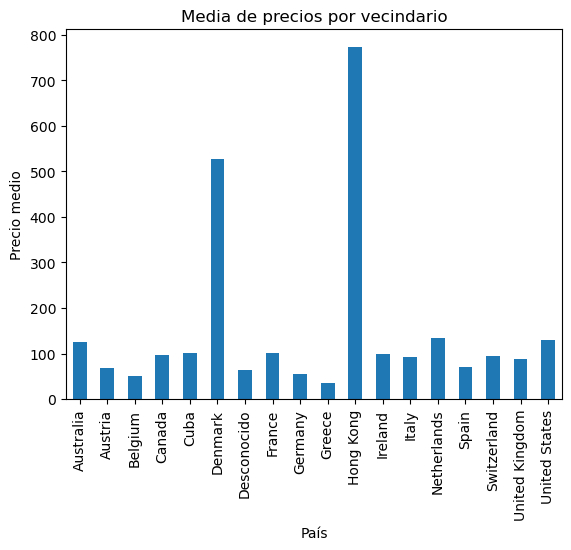

In [52]:
# Gráfico de barras
plt.figure(figsize=(12, 6))
country.plot(kind='bar', legend=None)
plt.title('Media de precios por vecindario')
plt.xlabel('País')
plt.ylabel('Precio medio')
plt.xticks(rotation=90)
plt.show()

Como podemos observar en el gráfico anterior, en el que se muestra el precio medio por vecindario, Hong kong lidera con un precio cercano a 800€, seguido de Dinamarca con un precio por debajo de los 600€. Se puede ver que la diferencia con el resto es muy amplia.

In [53]:
## LLama la atencion Honk Kong. Al tener solo tres datos puede que no tengamos una muestra demasiado representativa. Esto se corrige más adelante
print("Numero de AirBnB en Hong Kong: " + str(len(df[df["country"] == "Hong Kong"])))

Numero de AirBnB en Hong Kong: 3


In [54]:
# Revisión de los 10 estados donde más y con menos vale alojarse una noche
top_10_states = df[['state','price']].groupby('state').mean('price').round(2).sort_values(by = 'price', ascending = False).head(10)
under_10_states = df[['state','price']].groupby('state').mean('price').round(2).sort_values(by = 'price', ascending = True).head(10)

In [55]:
top_10_states

,price
state,
Copenhagen,907.00
Hong Kong Island,860.50
Danmark,748.00
Kowloon,597.00
Alicante,579.00
Hovedstaden,497.00
马德里自治区,446.59
马德里,282.67
TX,269.25


<Figure size 1200x600 with 0 Axes>

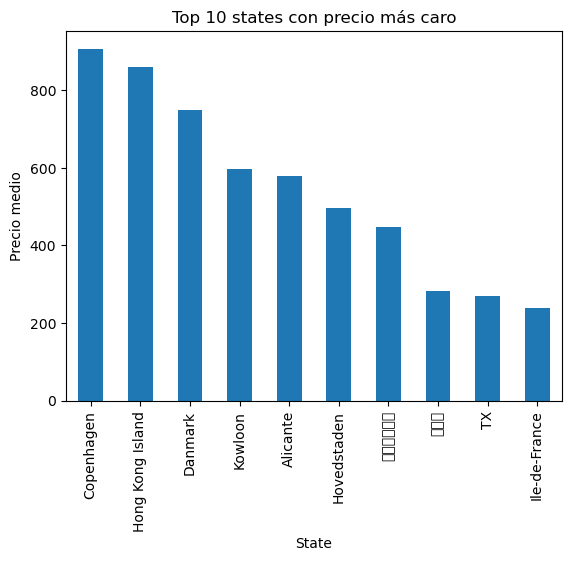

In [56]:
plt.figure(figsize=(12, 6))
top_10_states.plot(kind='bar', legend=None)
plt.title('Top 10 states con precio más caro')
plt.xlabel('State')
plt.ylabel('Precio medio')
plt.xticks(rotation=90)
plt.show()

Nuevamente nos encontramos con Dinamarca, esta vez solo con la capital, y Hong Kong a la cabeza de los lugares donde más caro es alojarse por una noche.

In [57]:
under_10_states

,price
state,
Madrid capital,18.0
Espańa,20.0
Região Autônoma de Madrid,20.0
Attica,25.0
Gran Mánchester,25.0
Brussels Hoofdstedelijk Gewest,28.0
stoke newington,30.0
"Madrid, Spain",30.0
madrid,31.1


<Figure size 1200x600 with 0 Axes>

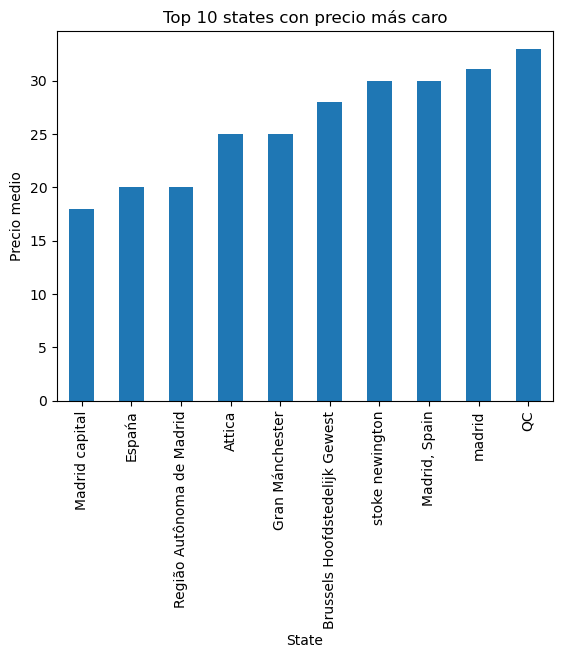

In [58]:
plt.figure(figsize=(12, 6))
under_10_states.plot(kind='bar', legend=None)
plt.title('Top 10 states con precio más caro')
plt.xlabel('State')
plt.ylabel('Precio medio')
plt.xticks(rotation=90)
plt.show()

Este gráfico nos muestra donde es más barato alojarse dentro de los datos que tenemos, donde nos encontramos Madrid o España en general.

In [59]:
#Creamos una lista con los states que contengan algo de Madrid para posteriormente hacer un replace y agruparlos todos en Madrid
filtered_df=df
filtered_df['state'] = filtered_df['state'].fillna('')

filtered_df = filtered_df.query("state.str.contains('Madrid')", engine='python')
unique_values_madrid=filtered_df['state'].unique()
replace_values = ['马德里自治区', '馬德里自治區', '西班牙', 'MADRID','madrid'] # Los madrid que no se podían leer con la query anterior por ser alfabeto chino
df['state'] = df['state'].replace(unique_values_madrid, 'Madrid')
df['state'] = df['state'].replace(replace_values, 'Madrid')
print("unique_values_madrid: " + str(unique_values_madrid))

filtered_df_cat=df
filtered_df_cat['state'] = filtered_df_cat['state'].fillna('')
filtered_df_cat = filtered_df_cat.query("state.str.contains('Catal')", engine='python')
unique_values_cat=filtered_df_cat['state'].unique()
df['state'] = df['state'].replace(unique_values_cat, 'Cataluña')
print("unique_values_cat: " + str(unique_values_cat))

filtered_df_bal=df
filtered_df_bal['state'] = filtered_df_bal['state'].fillna('')

filtered_df_bal = filtered_df_bal.query("state.str.contains('Bal')", engine='python')
unique_values_bal=filtered_df_bal['state'].unique()
df['state'] = df['state'].replace(unique_values_bal, 'Baleares')
print("unique_values_bal: " + str(unique_values_bal))

replace_values2 = ['Greater London','london','londres']
replace_value3 = ['Capital Region of Denmark','Danmark']

df['state'] = df['state'].replace('England', 'Inglaterra')
df['state'] = df['state'].replace(replace_values2, 'Londres')
df['state'] = df['state'].replace('County Dublin', 'Dublin')
df['state'] = df['state'].replace(replace_value3, 'Dinamarca')

unique_values_madrid: ['Comunidad de Madrid' 'Community of Madrid' 'Madrid'
 'Communauté de Madrid' 'Madrid España' 'Região Autônoma de Madrid'
 'Autonome Gemeinschaft Madrid' 'España,Madrid' 'Madrid \nMadrid'
 'Madrid capital' 'Madrid, Spain']
unique_values_cat: ['Catalunya' 'Catalonia' 'Cataluña, Catalonia' 'Cataluña']
unique_values_bal: ['Illes Balears' 'Balearic Islands' 'Islas Baleares' 'Baleares']


In [60]:
df['state'].unique()

array(['TX', 'Barcelona', 'Cataluña', 'North Holland', 'Vlaanderen', 'CT',
       'Desconocido', 'Noord-Holland', 'Île-de-France', 'Baleares',
       'Madrid', 'Salerno Fisciano', 'CA', 'Inglaterra', 'NY', 'Dublin',
       'Lazio', 'Bruxelles', 'DC', 'Vlaams Gewest', 'NH', 'BA', 'España',
       '马德里', 'Tower hamlet', 'NSW', 'WA', 'Attica', 'Berlin', 'PM',
       'London', 'Wien', 'Quebec', 'Vienna', 'MA', 'Venezia', 'Veneto',
       'VIC', 'Brussel', 'Alicante', 'IL', 'Copenhagen',
       'Valencian Community', 'Genève', 'ON', 'Hovedstaden', 'CO',
       'Londres', 'Dinamarca', 'Ile de France', 'BC', 'Ile-de-France',
       'Kowloon', 'Spain', 'Québec', 'Brussels Hoofdstedelijk Gewest',
       'Mallorca', 'La Habana', 'Whitechapel', 'stoke newington', 'LA',
       'Ginebra', 'Usera', 'New South Wales', 'Hong Kong Island',
       'City of Edinburgh', 'IB', 'Victoria', 'QC', 'IDF', '28', 'TN',
       'Brussels', 'UK', 'Berlín', 'Espańa', 'Gran Mánchester'],
      dtype=object)

In [61]:
## Eliminamos para intantar tener una mínima muestra significativa aquellos estados y paises donde no se tengan mas de 5 AirBnB
###### para quitar states que aparezcan menos de 3 veces: 
col_country = 'country'
col_state = 'state'

value_counts_country = df.loc[:, col_country].value_counts()
mask = df.loc[:, col_country].isin(value_counts_country[value_counts_country < 5].index)
df = df.drop(index=df[mask].index)

value_counts_state = df.loc[:, col_state].value_counts()
mask = df.loc[:, col_state].isin(value_counts_state[value_counts_state < 5].index)
df = df.drop(index=df[mask].index)

# Nuevas dimensiones de la tabla habiendo aplicado el filtrado anterior
print(df.shape)
df

(14695, 58)


,index,experiences_offered,host_since,host_response_time,host_listings_count,host_total_listings_count,neighbourhood,neighbourhood_group_cleansed,state,market,...,longitud,amenity_score,review_scores_location,review_scores_accuracy,review_scores_value,host_response_rate,review_scores_cleanliness,review_scores_checkin,review_scores_rating,review_scores_communication
1,1,none,2401.0,1.0,162.0,162.0,999.000000,91.991607,Barcelona,Barcelona,...,2.172625,42.0,10.000000,8.000000,10.000000,8.000000,10.000000,10.000000,80.000000,100.000000
2,2,none,2401.0,1.0,162.0,162.0,999.000000,91.991607,Barcelona,Barcelona,...,2.162173,42.0,10.000000,9.000000,10.000000,9.000000,10.000000,10.000000,89.000000,100.000000
3,3,none,4760.0,1.0,27.0,27.0,999.000000,91.991607,Barcelona,Barcelona,...,2.167418,135.0,9.000000,10.000000,10.000000,10.000000,10.000000,9.000000,92.000000,100.000000
4,4,none,2702.0,1.0,207.0,207.0,78.862048,91.991607,Cataluña,Barcelona,...,2.155150,61.0,8.000000,9.000000,10.000000,8.000000,8.000000,9.000000,70.000000,99.000000
5,5,none,2702.0,1.0,207.0,207.0,74.023699,91.991607,Cataluña,Barcelona,...,2.149577,49.0,8.000000,9.000000,10.000000,8.000000,8.000000,9.000000,70.000000,99.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14757,14774,none,4378.0,99.0,1.0,1.0,73.449971,73.524318,NY,New York,...,-73.898799,60.0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,80.000000,99.500000
14758,14775,none,3457.0,12.0,1.0,1.0,73.771939,75.879394,NY,New York,...,-73.939342,58.0,10.000000,9.000000,10.000000,10.000000,10.000000,10.000000,95.000000,100.000000
14759,14776,none,2265.0,99.0,1.0,1.0,73.566250,999.000000,Île-de-France,Paris,...,2.294045,56.0,9.218201,9.532168,9.621778,9.416012,9.647033,9.328883,91.697978,94.823461
14760,14777,none,2892.0,1.0,1.0,1.0,999.000000,999.000000,Île-de-France,Paris,...,2.316173,73.0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,94.000000,100.000000


## Correlaciones

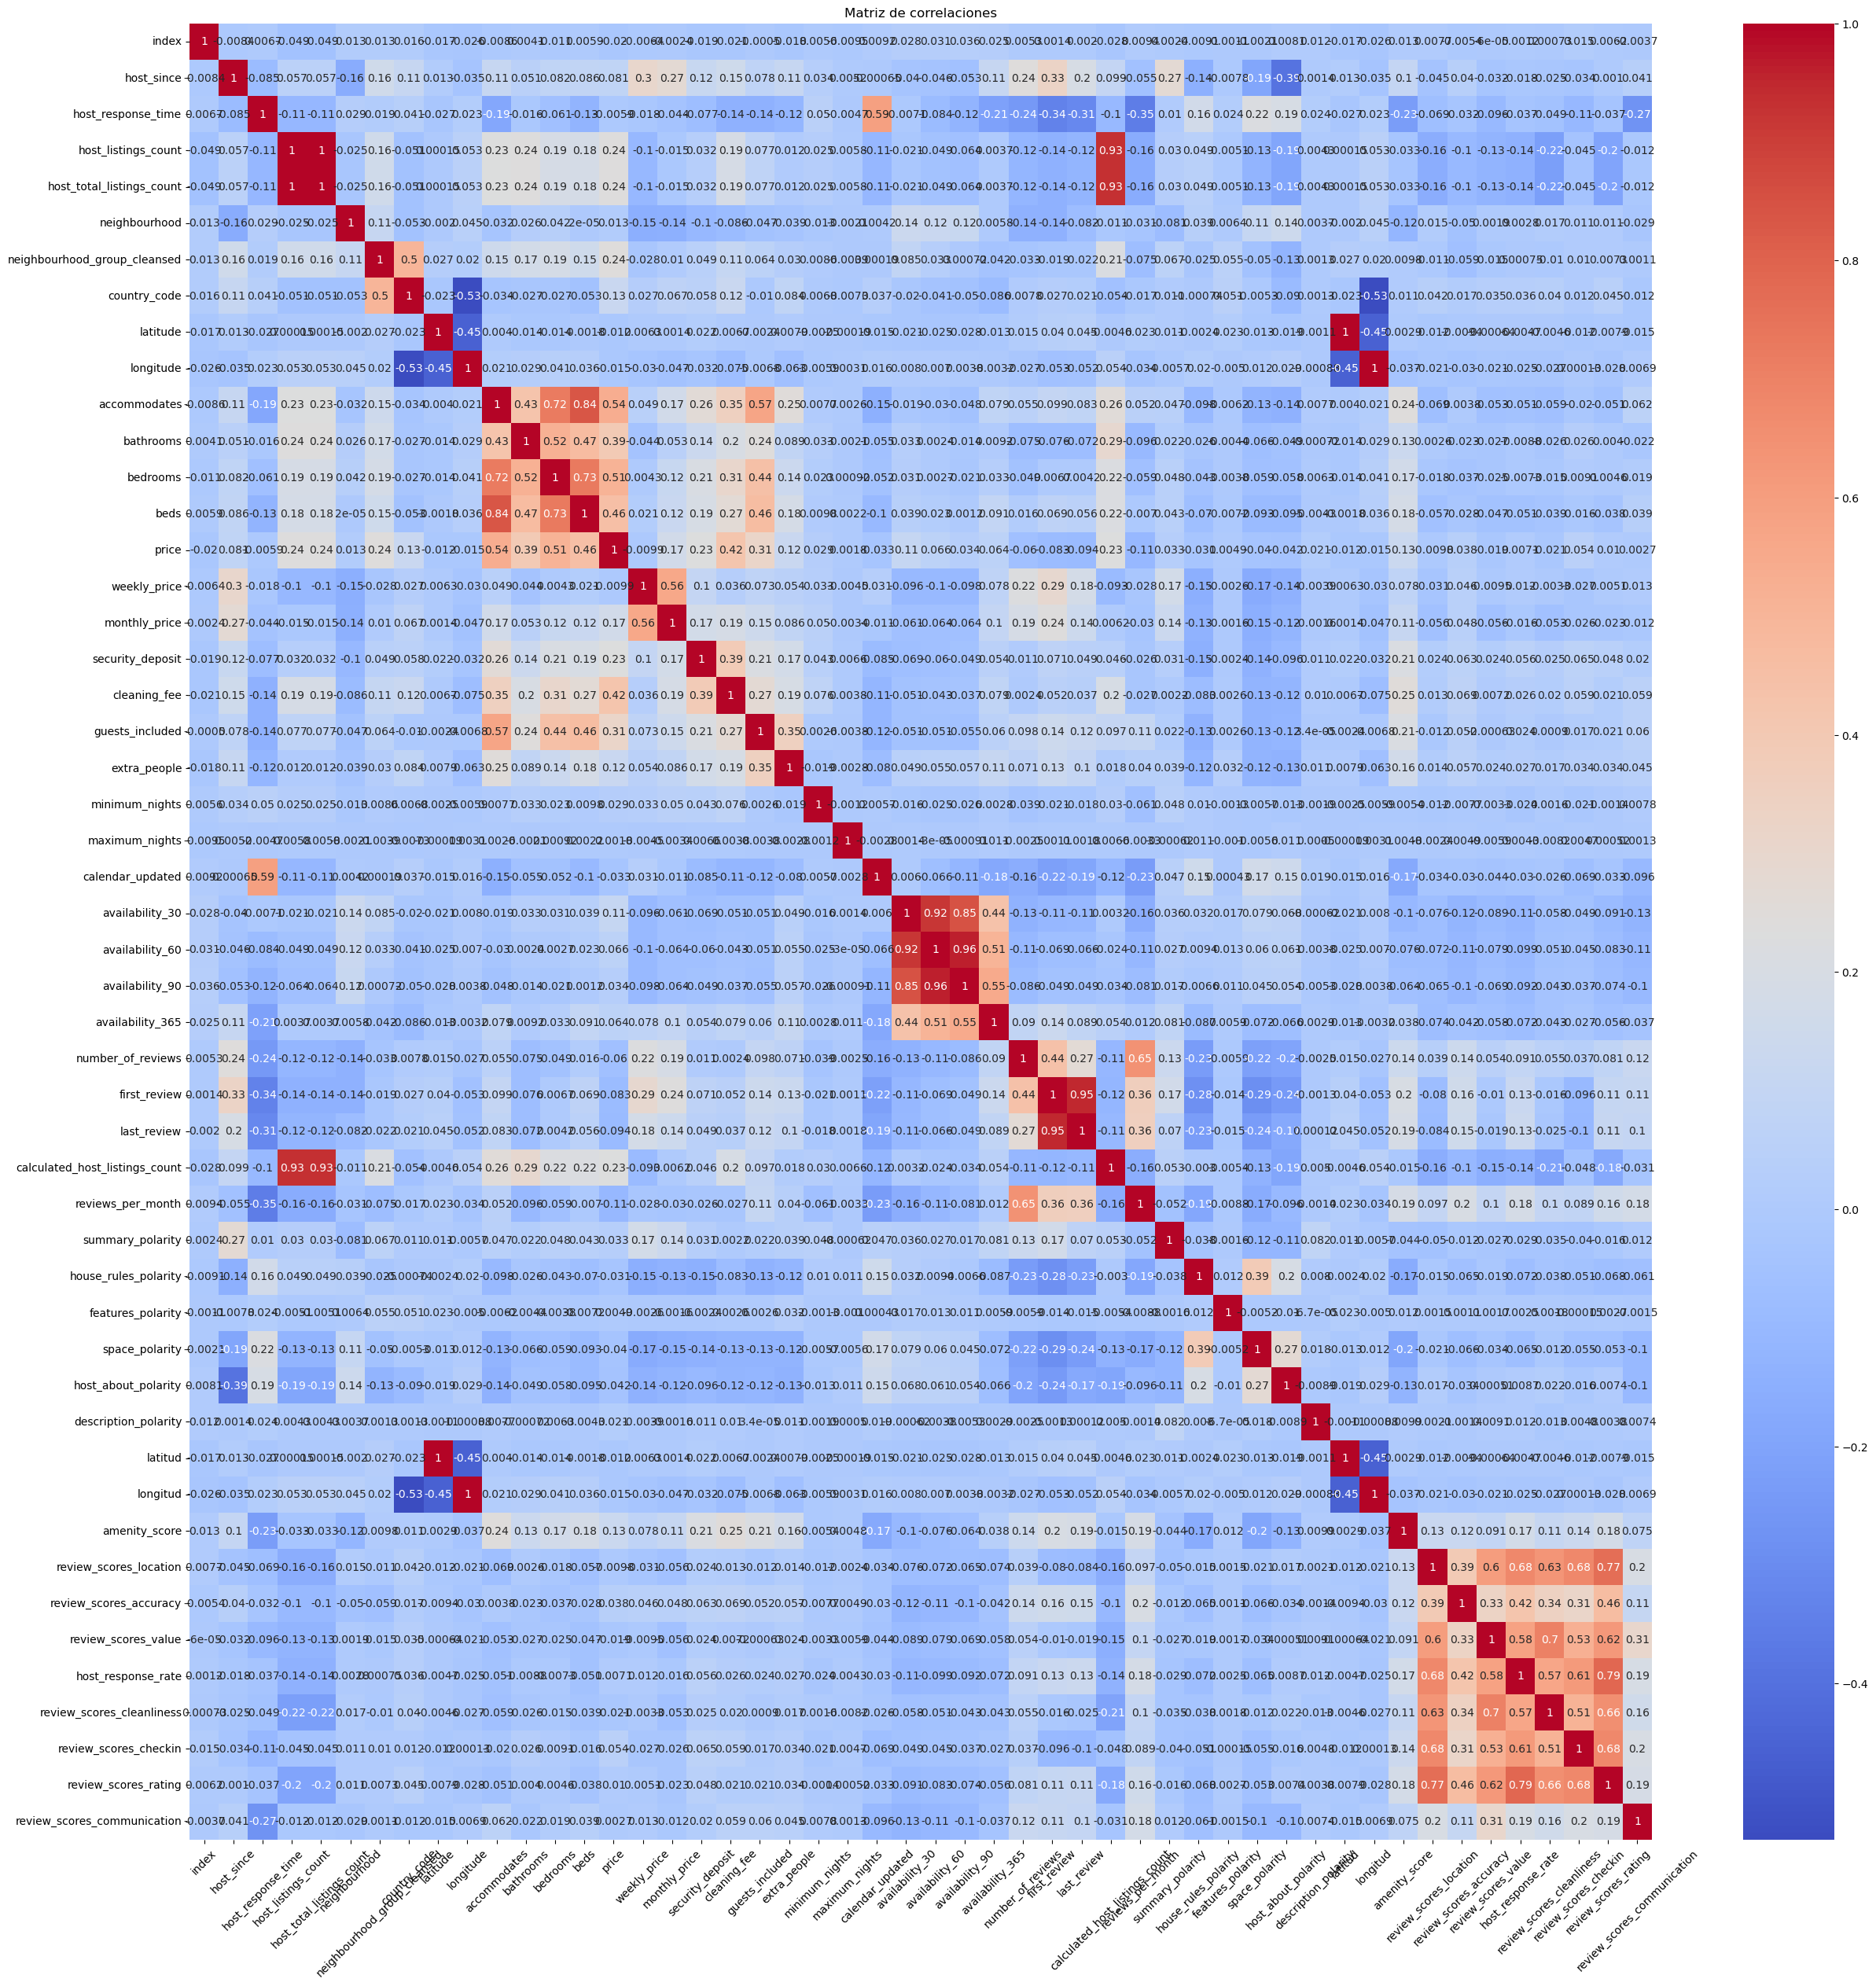

In [39]:

correlation_matrix = df.corr()


plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')


plt.title('Matriz de correlaciones')
plt.xticks(rotation=45)
plt.yticks(rotation=0)


plt.show()


* Conclusiones matriz de correlacion:  
* Hay un primer grupo en el que existe bastante correlacion entre las variables accomodates, bathrooms, bedrooms, y beds. Totalmente logico ya que pensando en una vivienda es normal que esten correlacionadas.
* Hay un segundo grupo que son las columnas de availability que tambien estan muy relacionadas entre si
* Las columnas de review tambien estan correlacionadas entre si, como es logico.

In [62]:
list_columns_before = df.columns
list_columns_before

Index(['index', 'experiences_offered', 'host_since', 'host_response_time',
       'host_listings_count', 'host_total_listings_count', 'neighbourhood',
       'neighbourhood_group_cleansed', 'state', 'market', 'country_code',
       'country', 'latitude', 'longitude', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'price',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'calendar_updated', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'first_review', 'last_review', 'cancellation_policy',
       'calculated_host_listings_count', 'reviews_per_month',
       'summary_polarity', 'house_rules_polarity', 'features_polarity',
       'space_polarity', 'host_about_polarity', 'description_polarity',
       'latitud', 'longitud', 'amenity_score', 'review_scores_location',

In [63]:
# Eliminamos tambien las columnas que tengan una correlacion con el precio muy cercana a 0
# Calculamos la matriz de correlaciones
correlation_matrix = df.corr()

# Obtenemos las columnas con una correlación de entre el 5% y -5% con el precio
columns_to_drop = correlation_matrix[(correlation_matrix['price'] >= -0.05) & (correlation_matrix['price'] <= 0.05)].index

# Se eliminan las columnas con la correlación obtenida anteriormente con el fin de crear un df con variables que ayuden a predecir el precio
df = df.drop(columns=columns_to_drop)

In [64]:
# Nuevas dimensiones de la tabla habiendo aplicado el filtrado anterior
df.shape

(14695, 33)

In [65]:
df.columns

Index(['experiences_offered', 'host_since', 'host_listings_count',
       'host_total_listings_count', 'neighbourhood_group_cleansed', 'state',
       'market', 'country_code', 'country', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'price',
       'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included',
       'extra_people', 'availability_30', 'availability_60',
       'availability_365', 'number_of_reviews', 'first_review', 'last_review',
       'cancellation_policy', 'calculated_host_listings_count',
       'reviews_per_month', 'amenity_score', 'review_scores_checkin'],
      dtype='object')

## Análisis gráfico de algunas variables

In [66]:
def analyze_column(column, target_column=None):
    distinct_values = column.nunique()
    column_info = f"Distinct values: {distinct_values}"
    
    if column.dtype == 'float' or column.dtype == 'int':
        column_info += f"\nMean: {column.mean()}\nMax: {column.max()}\nMin: {column.min()}"
    
    print(column_info)
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=column, y=target_column, data=df)
    plt.xlabel(column.name)
    plt.ylabel(target_column.name)
    plt.xticks(rotation=45)
    plt.title(f'{column.name} vs {target_column.name}')
    plt.show()


Distinct values: 17
Mean: 2.0361347397073835
Max: 16.0
Min: 0.0


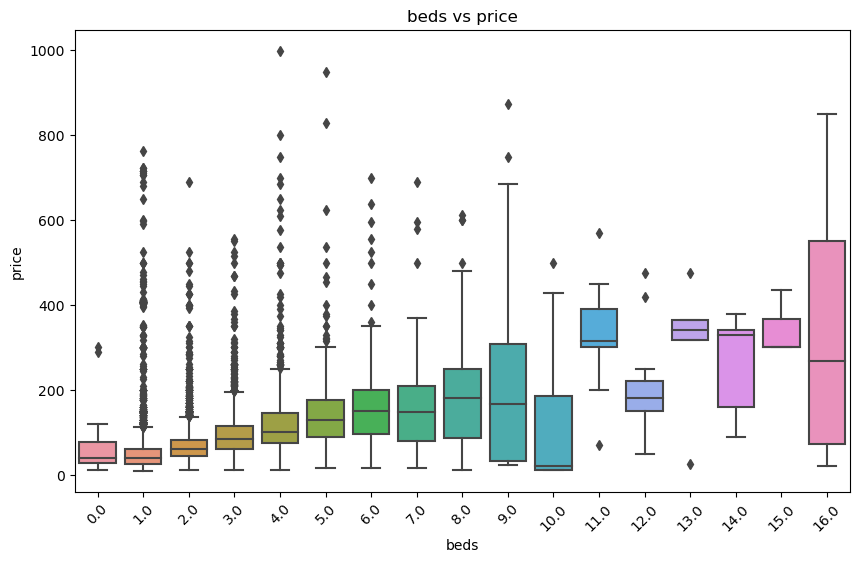

In [67]:
analyze_column(df['beds'], target_column=df['price'])

En este gráfico se puede ver una relación que a cuantas más habitaciones más caro sería el alojamiento. Además se puede comprobar que cuantas menos habitaciones tenga el Air Bnb más valores atípicos se pueden observar.

Distinct values: 32


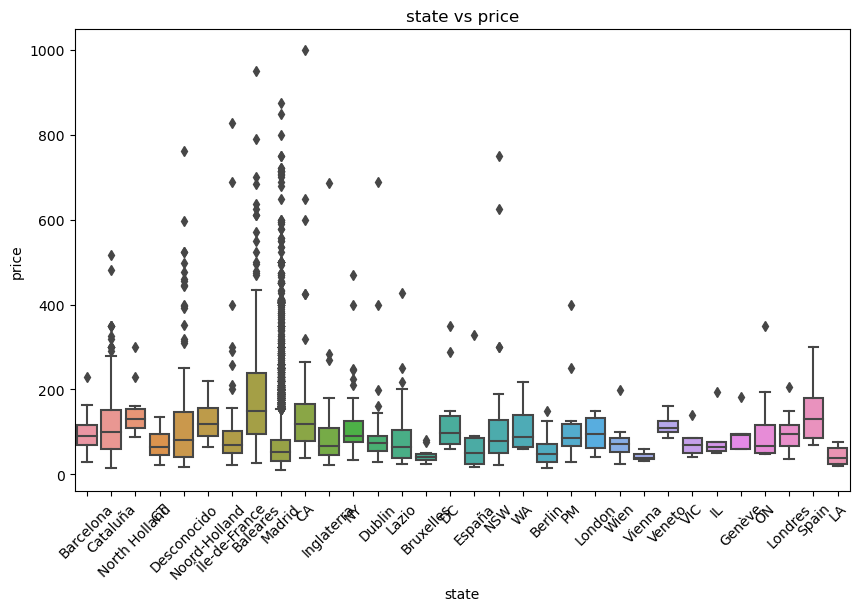

In [68]:
analyze_column(df['state'], target_column=df['price'])

Este gráfico nos muestra que aun existiendo datos atípicos, en general, el rango de precios se encuentra dentro de 0€ a 200€ en todos los estados

Distinct values: 3


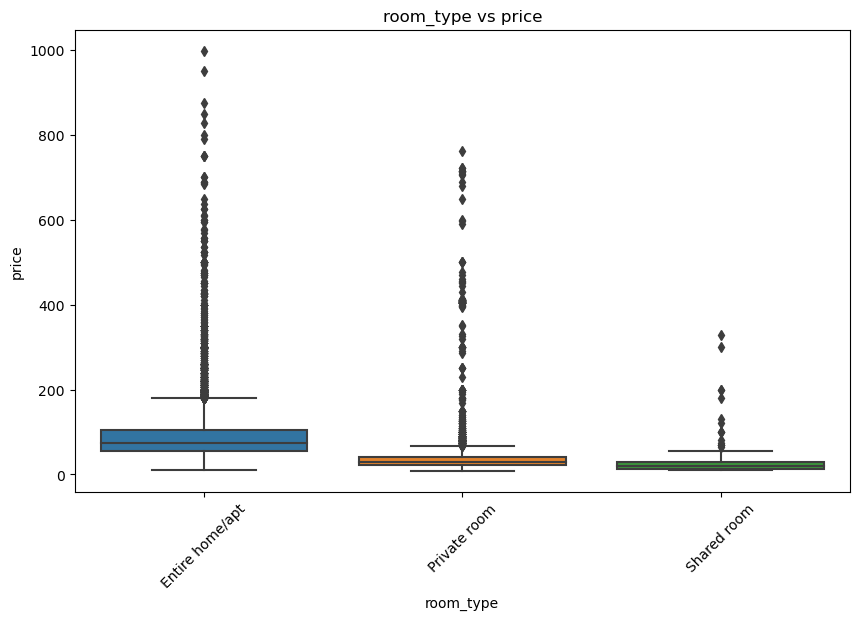

In [69]:
analyze_column(df['room_type'], target_column=df['price'])

El precio medio según el tipo de habitación no difiere mucho, encontrándose los tres tipos por debajo de 200€.

Distinct values: 145
Mean: 67.6284450493365
Max: 158.0
Min: 0.0


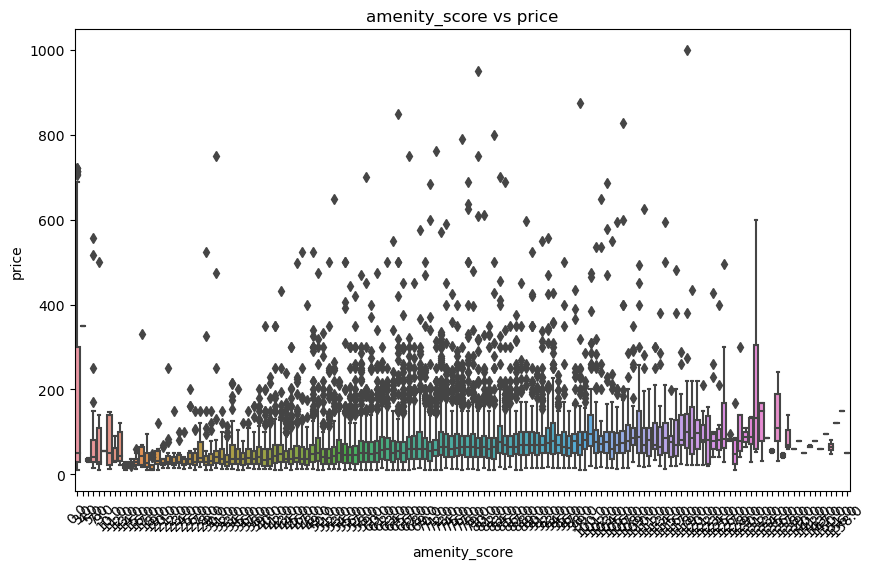

In [70]:
analyze_column(df['amenity_score'], target_column=df['price'])

In [71]:
#Nos quedamos solo con smart_location y country ya que recogen la misma información que estas columnas
df = df.drop(['neighbourhood_group_cleansed', 'state', 'country_code'], axis=1)

In [72]:
list(df.columns)

['experiences_offered',
 'host_since',
 'host_listings_count',
 'host_total_listings_count',
 'market',
 'country',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'guests_included',
 'extra_people',
 'availability_30',
 'availability_60',
 'availability_365',
 'number_of_reviews',
 'first_review',
 'last_review',
 'cancellation_policy',
 'calculated_host_listings_count',
 'reviews_per_month',
 'amenity_score',
 'review_scores_checkin']

## Análisis de outliers

* Se ha visto anteriormente como en los graficos boxplot del apartado anterior hay muchas columnas con datos outliers. El boxplot representa como outliers los valores que estén por encima o por debajo de 1,5 veces el rango intercurtilico de la columna. Hemos definido la siguiente funcion que tiene un multiplicador parametrizable (en este caso se ha decidido establecer 3) y se procede posteriormente a eliminar aquellos valores de las columnas elegidas 

In [73]:
list_var_continuous = []
for i in df.columns:
    if (df[i].dtype==float or df[i].dtype=='int64'):
        list_var_continuous.append(i)

In [74]:
def get_deviation_of_mean_perc(df, list_var_continuous, target, multiplier):
    """
    Devuelve el porcentaje de valores que exceden del intervalo de confianza
    """
    df_final = pd.DataFrame()
    
    for i in list_var_continuous:
        
        series_mean = df[i].mean()
        series_quantile = df[i].quantile([.2, .8])
        iqr = (series_quantile.iloc[1] - series_quantile.iloc[0])
        left_qr = series_mean - iqr * multiplier
        right_qr = series_mean + iqr * multiplier
        size_s = df[i].size
        
        perc_goods = df[i][(df[i] >= left_qr) & (df[i] <= right_qr)].size/size_s
        perc_excess = df[i][(df[i] < left_qr) | (df[i] > right_qr)].size/size_s
        list_index_rows = list(df[i][(df[i] < left_qr) | (df[i] > right_qr)].index)
        
        if perc_excess>0:    
            df_percent = pd.DataFrame(df[target][(df[i] < left_qr) | (df[i] > right_qr)]\
                                            .value_counts(normalize=True).reset_index()).T
            df_percent = df_percent.drop('index',axis=0)
            df_percent['variable'] = i
            df_percent['sum_outlier_values'] = df[i][(df[i] < left_qr) | (df[i] > right_qr)].size
            df_percent['index_outliers'] = str(list_index_rows)
            df_percent['porcentaje_sum_null_values'] = perc_excess
            df_final = pd.concat([df_final, df_percent], axis=0).reset_index(drop=True)
            
    if df_final.empty:
        print('No existen variables con valores nulos')
        
    return df_final

df_desv = get_deviation_of_mean_perc(df, list_var_continuous, target='price', multiplier=3)
df_desv = df_desv[['variable', 'sum_outlier_values', 'porcentaje_sum_null_values', 'index_outliers']]
df_desv

,variable,sum_outlier_values,porcentaje_sum_null_values,index_outliers
0,host_listings_count,1264,0.086016,"[1, 2, 4, 5, 8, 12, 13, 16, 23, 24, 28, 29, 46..."
1,host_total_listings_count,1264,0.086016,"[1, 2, 4, 5, 8, 12, 13, 16, 23, 24, 28, 29, 46..."
2,accommodates,258,0.017557,"[103, 104, 150, 322, 323, 386, 401, 429, 446, ..."
3,bathrooms,549,0.037360,"[62, 98, 112, 167, 202, 213, 219, 239, 278, 28..."
4,bedrooms,145,0.009867,"[289, 452, 516, 611, 786, 936, 1055, 1181, 128..."
5,beds,141,0.009595,"[103, 104, 289, 322, 386, 505, 770, 909, 964, ..."
6,price,315,0.021436,"[98, 121, 325, 362, 452, 591, 600, 615, 628, 6..."
7,monthly_price,469,0.031916,"[21, 35, 96, 207, 209, 302, 308, 309, 343, 348..."
8,security_deposit,97,0.006601,"[99, 272, 325, 330, 763, 804, 916, 957, 1088, ..."
9,cleaning_fee,139,0.009459,"[253, 323, 552, 680, 791, 880, 914, 916, 957, ..."


In [76]:
columns = ['monthly_price', 'review_scores_cleanliness', 'accommodates', 'price']
list_index_outliers_drop = df_desv[df_desv['variable'].isin(columns)].index_outliers
list_index_outliers_total = []
for i, n in enumerate(columns): 
    list_index_outliers_drop_ = eval(list(list_index_outliers_drop)[i])
    list_index_outliers_total = list_index_outliers_total + list_index_outliers_drop_
list_index_outliers_total = list(set(list_index_outliers_total))
print('len df: ' + str(len(df)))
df = df.drop(list_index_outliers_total)
df.reset_index(inplace = True)
print('len df_wo_outliers: ' + str(len(df)))

len df_wo_outliers: 13781


In [77]:
#Creamos un df de dummies de las columnas de las variables categóricas
df_dummies = pd.get_dummies(df)
df_dummies.shape

(13781, 114)

## Cluster

In [78]:
#Hacemos un Cluster para continuar con el análisis descriptivo

#Escalamos las variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_dummies)
df_normalized = pd.DataFrame(X_scaled, columns=df_dummies.columns)


In [79]:
df['price'].mean()

62.484725346491544

In [80]:
#Creamos el Cluster
# Seleccionar las variables para el clustering
X = df_dummies.drop(columns=['price'])

# Definir el número de clusters
num_clusters = 5

# Aplicar el algoritmo de K-means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Obtener las etiquetas de los clusters
labels = kmeans.labels_

# Agregar las etiquetas al DataFrame original
df['cluster'] = labels

#Numero de AirBnB por cluster
df['cluster'].value_counts()

2    3678
0    3624
1    3586
4    1466
3    1427
Name: cluster, dtype: int64

El análisis clúster ha generado un total de 5 clústeres. El clúster 2 contiene la mayor cantidad de elementos, con un total de 3678 observaciones asignadas. Le sigue de cerca el clúster 0, con 3624 observaciones asignadas. El clúster 1 también tiene una cantidad significativa de elementos, con 3586 observaciones asignadas. Por otro lado, los clústeres 4 y 3 presentan una menor cantidad de elementos, con 1466 y 1427 observaciones asignadas, respectivamente.

In [81]:
# Evaluacion de las caracteristicas de cada cluster
df_groupby=df[['cluster','country','bedrooms','beds','bathrooms','price']]
df_groupby.groupby('cluster').mean()

,bedrooms,beds,bathrooms,price
cluster,,,,
0,1.239238,1.891280,1.198813,61.594647
1,1.246235,1.915226,1.197853,60.076687
2,1.264002,1.898314,1.193583,63.315389
3,1.247372,1.708479,1.319902,64.733006
4,1.259891,1.732606,1.336289,66.302865


Al examinar las características de vivienda y los precios en cada clúster, podemos observar algunas tendencias interesantes.

En el clúster 0, las viviendas tienden a tener en promedio 1.239238 dormitorios, 1.891 camas y 1.198 baños, con un precio promedio de 61.59€.

El clúster 1 muestra características de vivienda similares al clúster 0, con ligeras variaciones. Las viviendas en este clúster tienen un promedio de 1.246 dormitorios, 1.915 camas y 1.197 baños, con un precio promedio de 60.076€.

Por otro lado, el clúster 2 presenta una ligera diferencia en las características de vivienda en comparación con los clústeres anteriores. Aquí, las viviendas tienen un promedio de 1.26 dormitorios, 1.898 camas y 1.193 baños, con un precio promedio de 63.31€.

El clúster 3 destaca por tener una mayor cantidad de baños en comparación con los otros clústeres. Las viviendas en este clúster tienen un promedio de 1.247 dormitorios, 1.708 camas y 1.319 baños, con un precio promedio de 64.73€.

Por último, en el clúster 4 también se observa un mayor número de baños y dormitorios. Las viviendas en este clúster tienen un promedio de 1.259891 dormitorios, 1.73 camas y 1.336 baños, con un precio promedio de 66.30€.

Estos resultados sugieren que los clústeres pueden estar relacionados con diferentes características y precios de vivienda. Por ejemplo, los clústeres 3 y 4 muestran una tendencia hacia viviendas con más baños y dormitorios, lo cual podría indicar una categoría de viviendas de mayor tamaño y precio. Sin embargo, es importante tener en cuenta que estos comentarios se basan únicamente en las características proporcionadas y se pueden realizar análisis más detallados si se dispone de información adicional o se considera el contexto completo del conjunto de datos utilizado en el análisis de agrupamiento.

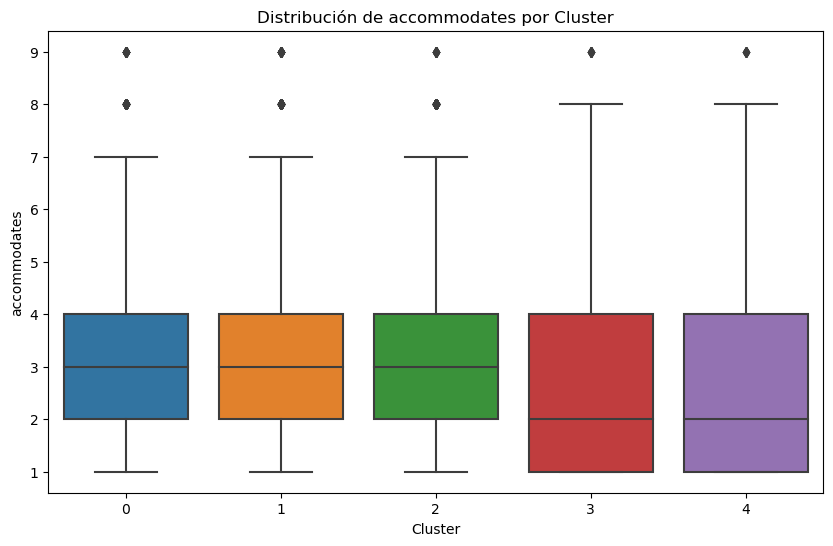

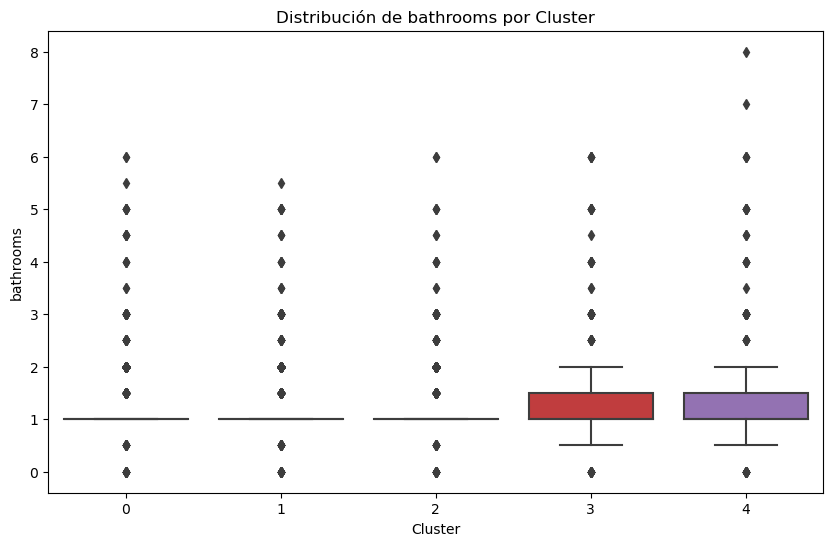

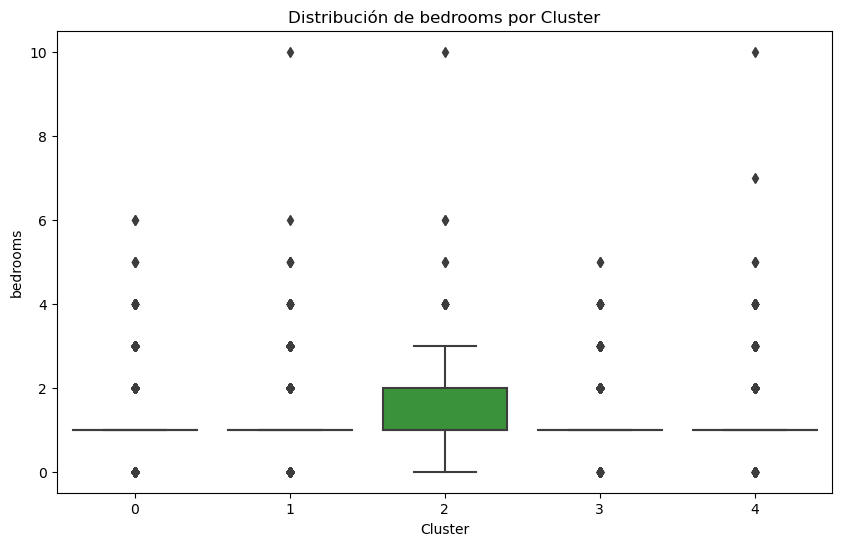

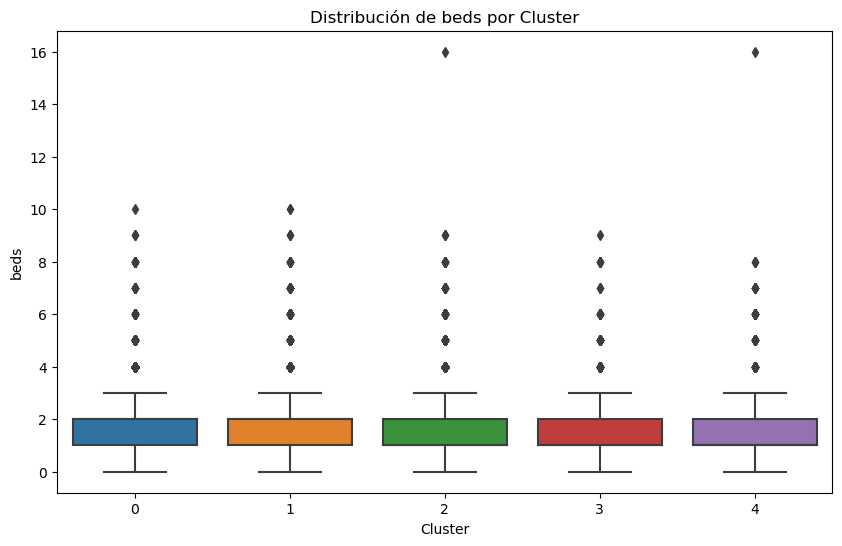

In [82]:
# Comparamos las distribuciones de variables numéricas por cluster
variables_numericas = ['accommodates', 'bathrooms', 'bedrooms', 'beds']

for variable in variables_numericas:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cluster', y=variable, data=df)
    plt.xlabel('Cluster')
    plt.ylabel(variable)
    plt.title(f'Distribución de {variable} por Cluster')
    plt.show()

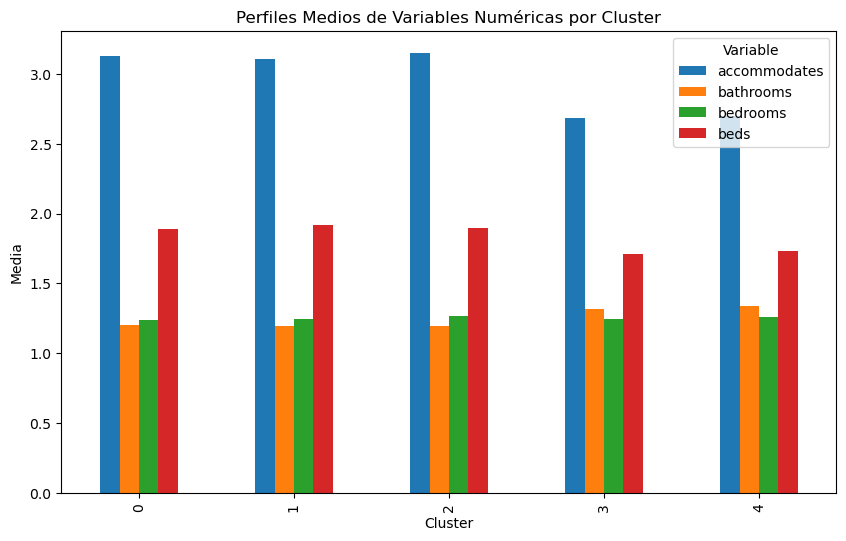

In [83]:
# Calculamos perfiles medios de variables numéricas por cluster
perfiles_medios = df.groupby('cluster')[variables_numericas].mean()

# Visualizar perfiles medios
perfiles_medios.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Cluster')
plt.ylabel('Media')
plt.title('Perfiles Medios de Variables Numéricas por Cluster')
plt.legend(title='Variable')
plt.show()


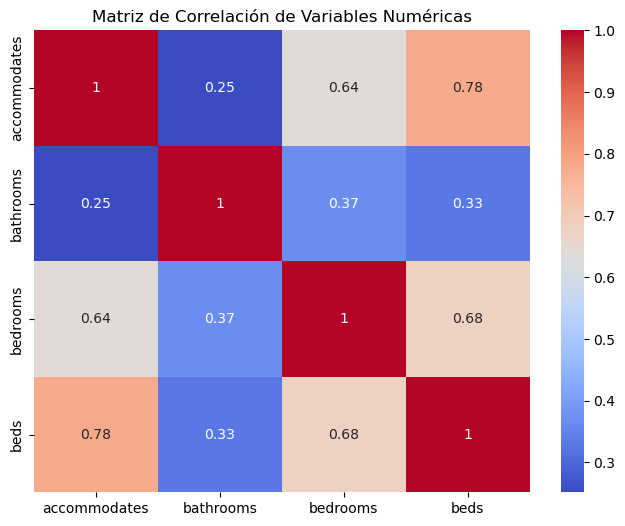

In [84]:
# Calcular matriz de correlación
matriz_correlacion = df[variables_numericas].corr()

# Visualizar mapa de calor de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()


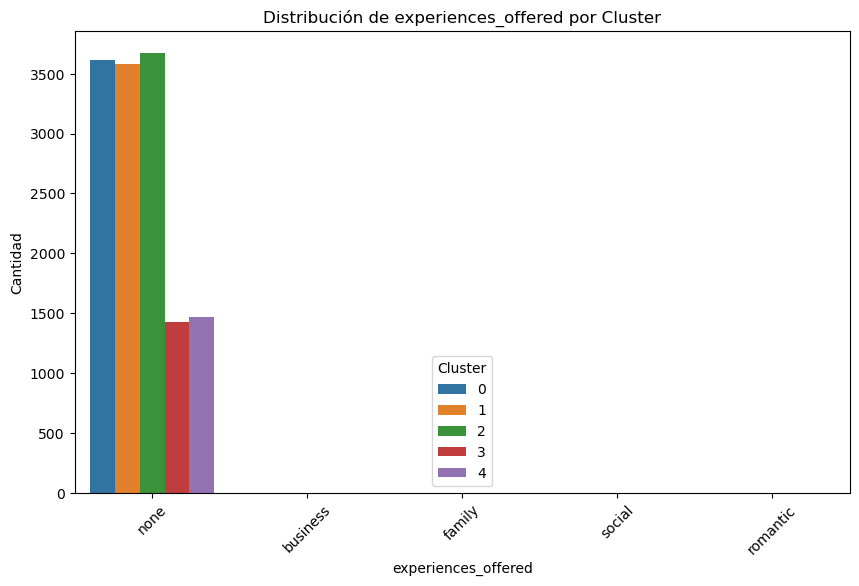

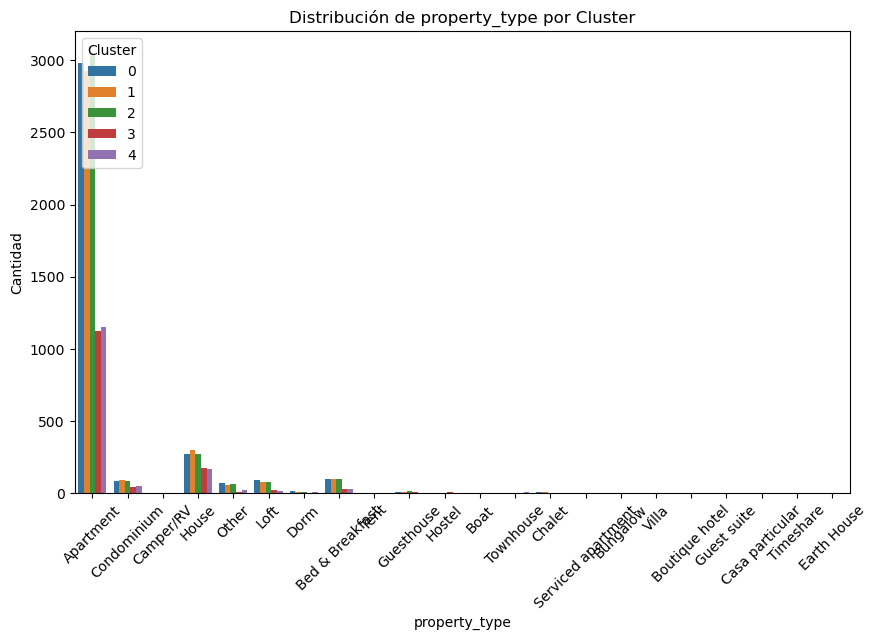

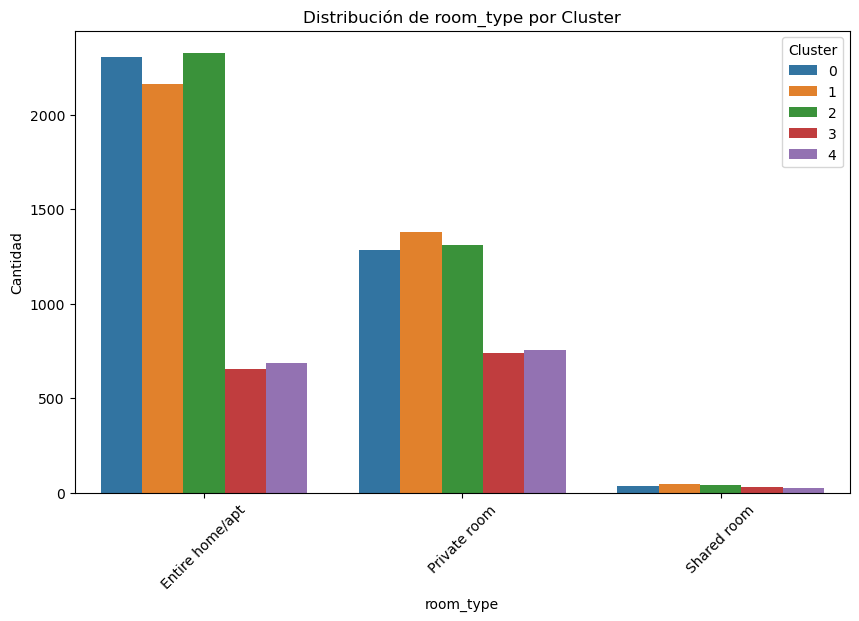

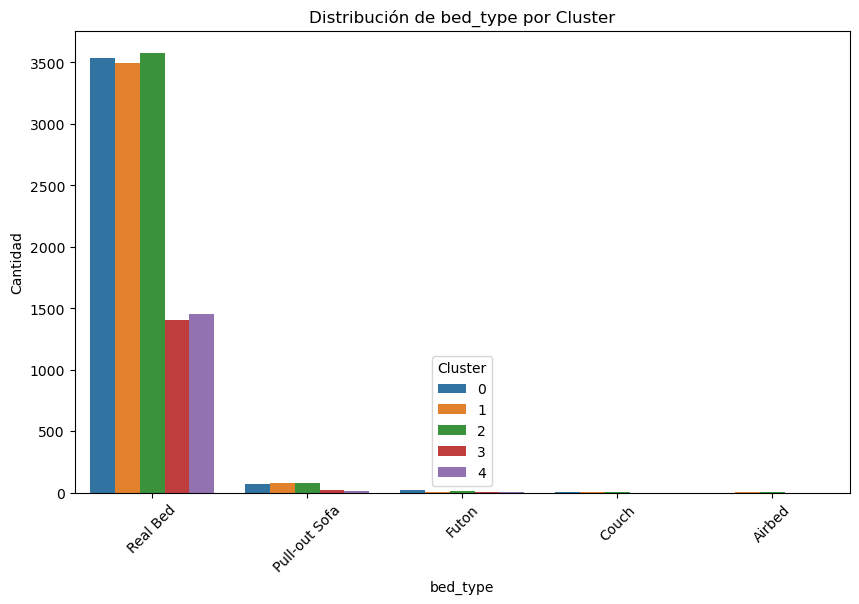

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

# Comparar distribuciones de variables categóricas por cluster
variables_categoricas = ['experiences_offered', 'property_type', 'room_type', 'bed_type']

for variable in variables_categoricas:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=variable, hue='cluster', data=df)
    plt.xlabel(variable)
    plt.ylabel('Cantidad')
    plt.title(f'Distribución de {variable} por Cluster')
    plt.legend(title='Cluster')
    plt.xticks(rotation=45)
    plt.show()


In [86]:
df_final_mean_grouped = df.groupby('cluster').mean()
df_final_mean_grouped

,index,host_since,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,monthly_price,...,availability_30,availability_60,availability_365,number_of_reviews,first_review,last_review,calculated_host_listings_count,reviews_per_month,amenity_score,review_scores_checkin
cluster,,,,,,,,,,,,,,,,,,,,,
0,7443.131623,3228.995585,8.382726,8.382726,3.125552,1.198813,1.239238,1.891280,61.594647,216.795530,...,8.251656,22.067605,206.608996,28.779249,2756.362859,2353.616446,6.739238,1.912638,69.618929,9.307696
1,12331.952872,3205.469325,8.740100,8.740100,3.106804,1.197853,1.246235,1.915226,60.076687,209.881205,...,8.639710,23.043503,210.057446,28.485499,2748.037089,2352.765198,7.190463,1.906868,69.594534,9.350739
2,2490.215334,3226.110386,10.315389,10.315389,3.150353,1.193583,1.264002,1.898314,63.315389,204.827080,...,8.014954,21.577488,202.904296,28.460848,2746.678902,2349.967645,7.622621,1.887822,69.466558,9.315049
3,11101.569026,2986.953749,18.508760,18.508760,2.681149,1.319902,1.247372,1.708479,64.733006,-6.637001,...,10.456202,24.607568,175.246671,0.000000,-99.000000,-99.000000,13.306237,0.000000,60.089699,9.541904
4,3765.777626,2965.185539,22.303547,22.303547,2.695089,1.336289,1.259891,1.732606,66.302865,8.886085,...,10.317872,24.304911,173.727831,0.000000,-99.000000,-99.000000,15.347885,0.000000,58.129604,9.523933


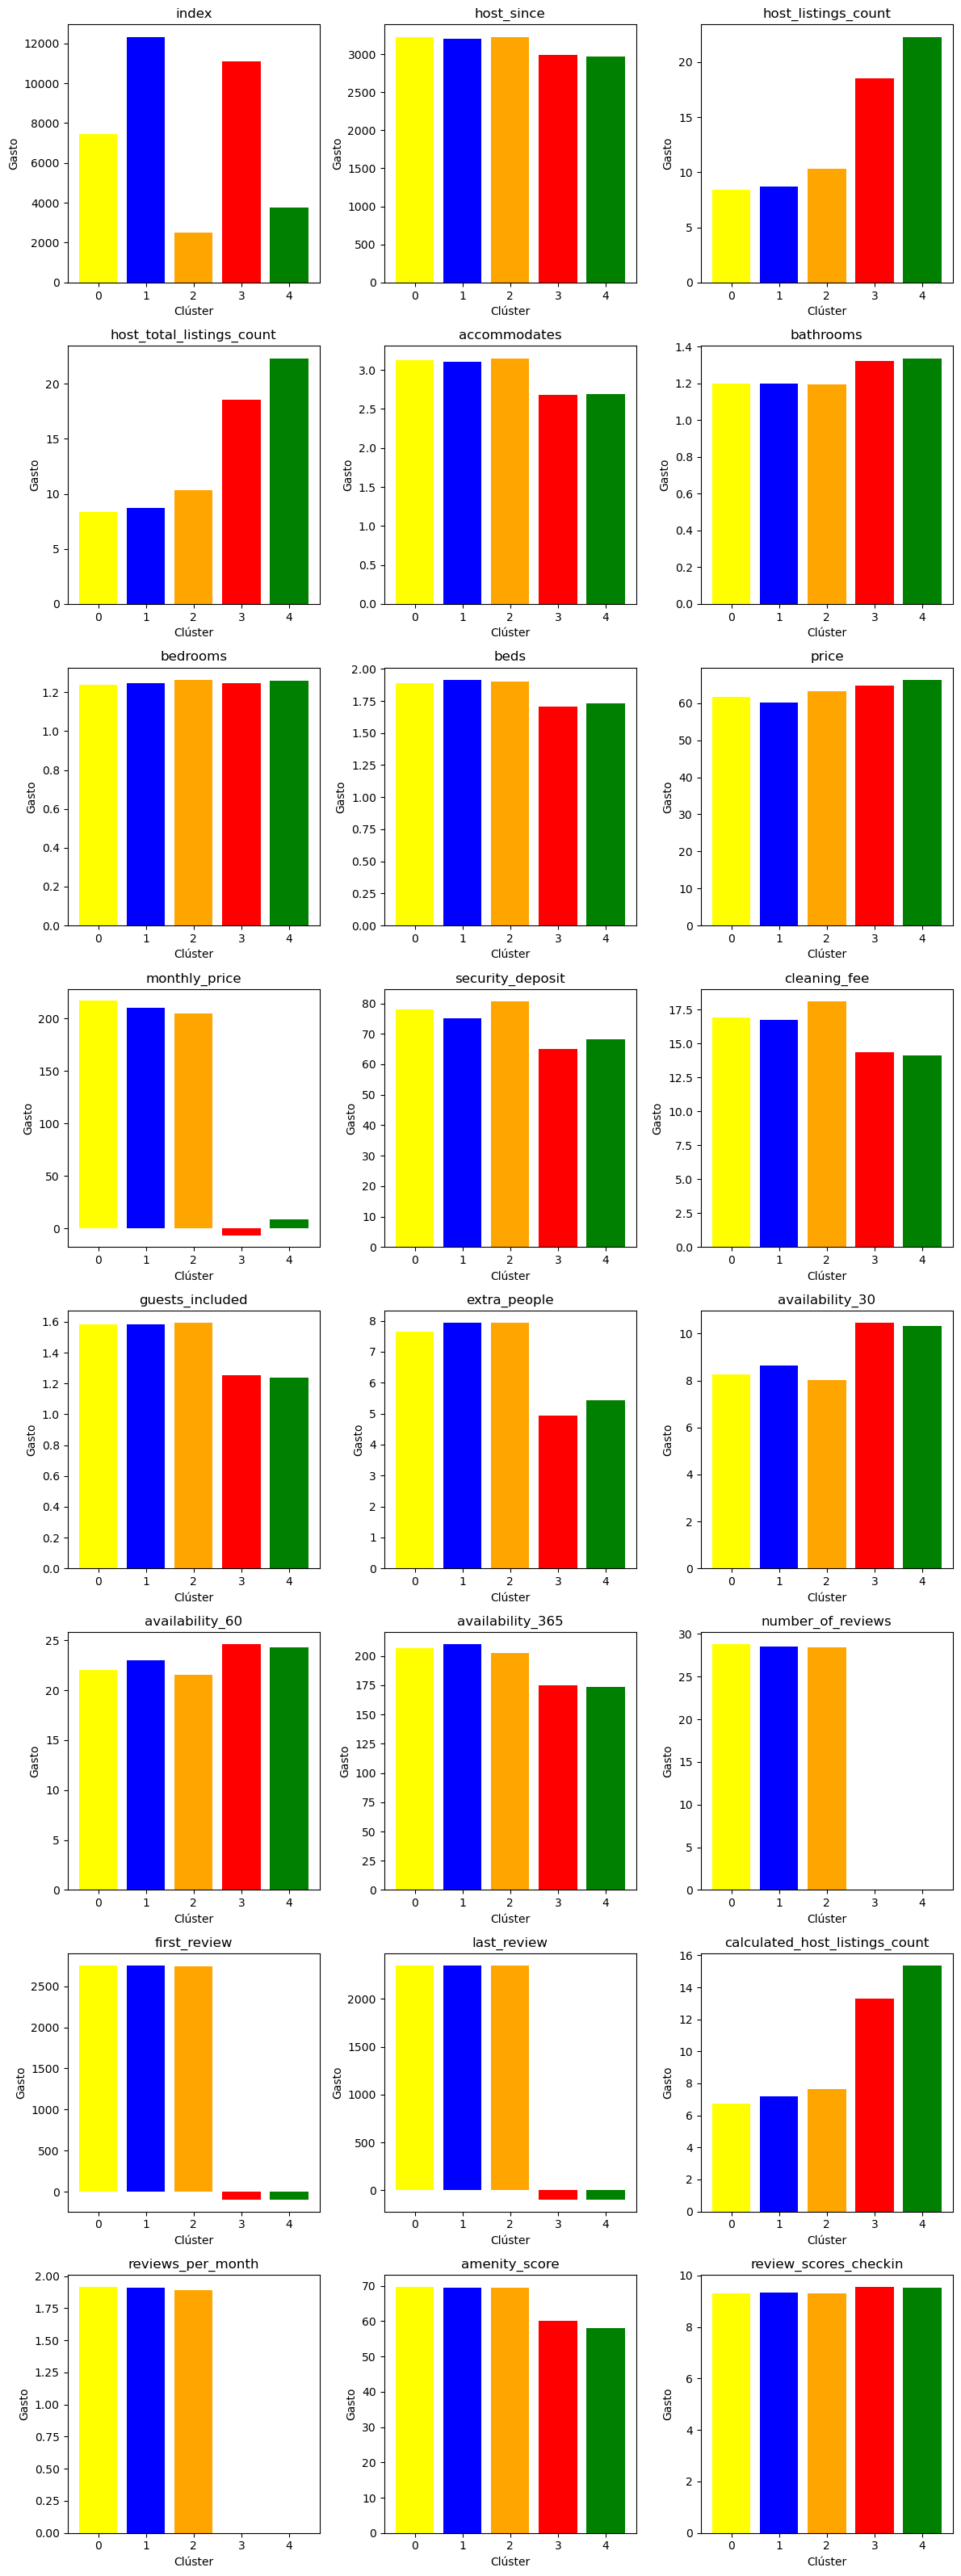

In [87]:
columns = df_final_mean_grouped.columns
graficos_por_fila = 3

total_filas = (len(columns) - 1) // graficos_por_fila + 1

colors = ['blue', 'orange', 'red', 'green', 'purple', 'yellow'] 

plt.figure(figsize=(12, 4 * total_filas))

for i, columna in enumerate(columns):
    posicion = i + 1

    plt.subplot(total_filas, graficos_por_fila, posicion)

    clusters = df_final_mean_grouped.index
    valores = df_final_mean_grouped[columna].values
    colores_cluster = [colors[cluster-1] for cluster in clusters]

    plt.bar(clusters, valores, color=colores_cluster)

    plt.title(columna)
    plt.xlabel('Clúster')
    plt.ylabel('Gasto')

plt.tight_layout()

plt.show()


## PCA

Realizaremos un pca con el fin obtener un df con una información más detallada para aplicarlo a los modelos. 
Al aplicar PCA, se logra reducir la dimensionalidad del conjunto de datos, lo que puede ser beneficioso en varias formas. En primer lugar, al eliminar la redundancia y la multicolinealidad entre las variables, se evita el problema de la maldición de la dimensionalidad y se mejora la eficiencia computacional. Además, al reducir la dimensionalidad, es posible visualizar y comprender mejor la estructura de los datos, lo que puede ayudar a identificar patrones y relaciones ocultas.
Una vez realizado el PCA, el nuevo DataFrame obtenido puede utilizarse en modelos de aprendizaje automático. Al tener una representación más compacta de los datos, es probable que los modelos se beneficien al trabajar con un conjunto de variables más significativas y menos ruidosas. Además, si el PCA ha capturado de manera efectiva la estructura subyacente de los datos, es posible que se logre un mejor rendimiento predictivo al entrenar los modelos con este nuevo conjunto de variables.

In [88]:
#Función que coge las variables categóricas y mete cada una en una lista de uniques para así poder ver cuales de estas columnas podemos quitar para poder hacer el pca
def obtener_listas_unicas(df):
    listas_unicas = {}

    for columna in df.columns:
        if df[columna].dtype == 'object':
            valores_unicos = df[columna].unique().tolist()
            nombre_lista = f'valores_unique_{columna}'
            listas_unicas[nombre_lista] = valores_unicos

    return listas_unicas



In [89]:
#Código para ver los nombres de de las listas dentro del diccionario

resultados = obtener_listas_unicas(df)

nombres_listas = list(resultados.keys())

for nombre_lista in nombres_listas:
    print(nombre_lista)

valores_unique_experiences_offered
valores_unique_market
valores_unique_country
valores_unique_property_type
valores_unique_room_type
valores_unique_bed_type
valores_unique_cancellation_policy


In [90]:
# Analizamos los resultados de las listas
nombres_listas = list(resultados.keys())

nombre_lista = nombres_listas[4]#Si vas cambiando de número t salen las distintas listas, empezando por el 0  
valores = resultados[nombre_lista]

print(valores)
#Eliminar valores_unique_street,valores_unique_neighbourhood_cleansed,

['Entire home/apt', 'Private room', 'Shared room']


In [91]:
#Separamos los datos en train y test
#Entrenamos los datos
#df_train, df_test = train_test_split( X_scaled, test_size=1/7.0, random_state=0)
X = df_normalized.drop('price', axis=1)
y = df_normalized['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Train dataset:', X_train.shape)
print('Test dataset:', X_test.shape)

Train dataset: (11024, 113)
Test dataset: (2757, 113)


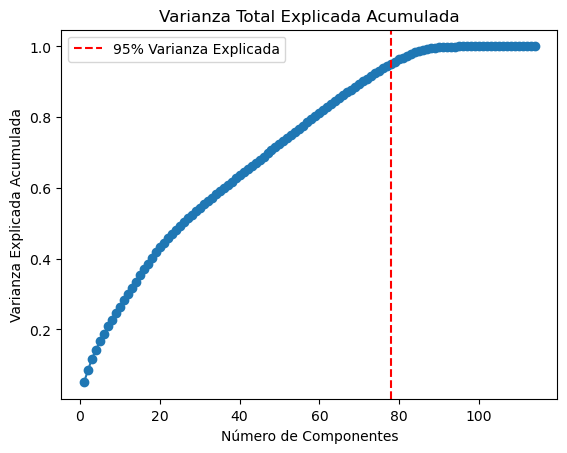

Columnas más importantes para el primer componente: accommodates, price, room_type_Entire home/apt, room_type_Private room, beds, cleaning_fee, bedrooms, guests_included, calculated_host_listings_count, host_listings_count

Columnas más importantes para el segundo componente: market_Madrid, country_Spain, first_review, last_review, reviews_per_month, host_total_listings_count, host_listings_count, calculated_host_listings_count, number_of_reviews, country_United Kingdom


In [92]:
# Realizar PCA
pca = PCA()
pca.fit(df_normalized)

# Obtener las varianzas explicadas por cada componente
explained_variances = pca.explained_variance_ratio_

# Obtener las columnas más importantes para el primer componente
first_component_loadings = np.abs(pca.components_[0])
most_important_first = df_normalized.columns[np.argsort(-first_component_loadings)]

# Obtener las columnas más importantes para el segundo componente
second_component_loadings = np.abs(pca.components_[1])
most_important_second = df_normalized.columns[np.argsort(-second_component_loadings)]

# Calcular la varianza total explicada acumulada
cumulative_variances = np.cumsum(explained_variances)

# Encontrar el número de componentes necesarios para el 95% de varianza explicada
n_components_95 = np.argmax(cumulative_variances >= 0.95) + 1

# Graficar la varianza total explicada acumulada
plt.plot(range(1, len(cumulative_variances) + 1), cumulative_variances, marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Total Explicada Acumulada')
plt.axvline(x=n_components_95, color='r', linestyle='--', label='95% Varianza Explicada')
plt.legend()
plt.show()

# Imprimir los resultados
print(f"Columnas más importantes para el primer componente: {', '.join(most_important_first[:10])}")
print("")
print(f"Columnas más importantes para el segundo componente: {', '.join(most_important_second[:10])}")


El gráfico de la varianza explicada acumulada y el número de componentes proporciona una visión clara de cuánta información se conserva a medida que aumentamos el número de componentes principales en el PCA.

En el eje x del gráfico, se representa el número de componentes principales considerados, mientras que en el eje y se muestra la varianza explicada acumulada. La varianza explicada acumulada indica el porcentaje total de varianza en los datos originales que se conserva al utilizar los primeros n componentes principales.

Al observar el gráfico, podemos ver cómo la varianza explicada acumulada aumenta a medida que se incorporan más componentes principales. En general, se espera que las primeras componentes principales expliquen la mayor parte de la variabilidad en los datos, y, por lo tanto, la varianza explicada acumulada aumenta rápidamente al principio. A medida que se agregan más componentes, el incremento en la varianza explicada acumulada tiende a ser más gradual.

El gráfico de la varianza explicada acumulada nos permite tomar decisiones informadas sobre cuántos componentes principales seleccionar para nuestro análisis. Podemos identificar el punto en el gráfico donde la curva se estabiliza y alcanza un nivel de varianza explicada satisfactorio. Este punto puede considerarse como un equilibrio entre la capacidad de representación de los datos y la reducción de la dimensionalidad.

In [93]:
# 78 componentes explican el 95% de la varianza
n_components_95

78

In [94]:
# Aplicamos el PCA con las 78 componentes que explican el 95% de la varianza
pca = PCA(n_components=78)
X_pca = pca.fit_transform(df_normalized) 

# Obtener la varianza explicada por cada componente
explained_variance_ratio = pca.explained_variance_ratio_

# Crear un DataFrame con la varianza explicada por cada componente
df_variance = pd.DataFrame({'Component': range(1, len(explained_variance_ratio)+1),
                            'Explained Variance Ratio': explained_variance_ratio})


In [95]:
df_variance

,Component,Explained Variance Ratio
0,1,0.049987
1,2,0.034101
2,3,0.033000
3,4,0.025721
4,5,0.023012
...,...,...
73,74,0.007340
74,75,0.007026
75,76,0.006937
76,77,0.006885


In [96]:
df_PCA = pd.DataFrame(X_pca)
df_PCA.head()

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,6.062114,5.821657,-4.667487,-0.321872,-4.879836,3.342212,4.618157,0.737324,0.005390,0.143826,...,1.954996,0.577931,0.854304,0.581548,3.172995,-8.665185,-2.213628,3.942421,-0.759728,9.408695
1,5.980925,6.930813,-5.711114,-0.318114,-5.073227,2.907838,3.318690,0.304904,0.073858,0.252735,...,2.280826,0.491163,1.032327,0.441729,2.817151,-8.545868,-2.332520,4.052865,-0.306860,9.136710
2,7.822369,1.009692,-0.039875,-0.309603,0.848050,-0.585623,0.713931,0.228899,0.145024,0.043148,...,-0.183021,0.465061,-1.093447,0.502120,-0.463058,-0.714059,1.801747,-0.767189,0.865802,-2.744275
3,5.440961,6.347789,-5.071564,-0.671085,-5.151433,2.199422,0.878652,0.907062,-0.762931,0.116432,...,-0.325133,0.070472,-0.274591,-0.115043,-0.195198,0.451986,0.383114,-0.554939,1.075254,-3.451531
4,5.484066,6.130614,-5.186439,-0.587487,-5.175489,2.683757,1.702611,1.058076,-0.642841,-0.151177,...,0.258980,-0.144483,0.068091,-0.258571,-0.485488,0.003020,1.083035,-1.386044,0.452185,-2.734480


## Gradient Boost

In [97]:
X = df_dummies.drop('price', axis=1) 
y = df_dummies['price']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

boost = GradientBoostingRegressor()
boost.fit(X_train, y_train)

boost_pred_y = boost.predict(X_test)

score_train_XGB = boost.score(X_train, y_train)

print("Score en los datos de train:", score_train_XGB)

mse_XGB = mean_squared_error(y_test, boost_pred_y)
print("Mean Squared Error (MSE) en los datos de test:", mse_XGB)

mae_XGB = mean_absolute_error(y_test, boost_pred_y)
print("Mean Absolute Error (MAE) en los datos de test:", mae_XGB)

r2_XGB = r2_score(y_test, boost_pred_y)
print("Coeficiente de determinación R² en los datos de test:", r2_XGB)

Score en los datos de train: 0.72640460476265
Mean Squared Error (MSE) en los datos de test: 540.9423281339393
Mean Absolute Error (MAE) en los datos de test: 15.443583768923782
Coeficiente de determinación R² en los datos de test: 0.6845856540479676


In [77]:
# Visualizamos en la siguiente tabla la precisión del modelo sobre una muestra de 20 alojamientos en el df test
df_y_test = pd.DataFrame(y_test)
df_y_test["predicted_price"] = boost_pred_y
df_y_test.head(20)

,price,predicted_price
11098,15.0,24.059437
8144,61.0,59.701265
6618,66.0,53.695425
181,72.0,57.987758
5826,20.0,26.703417
9459,91.0,68.827116
13607,45.0,49.141798
169,50.0,71.788089
9808,26.0,39.084791
468,30.0,28.435582


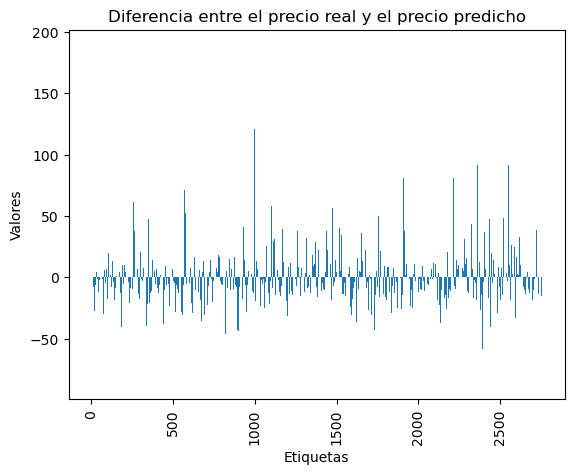

In [81]:
df_y_test["diff_price"] = df_y_test["price"] - df_y_test["predicted_price"]
df_y_test.reset_index(inplace = True)

plt.bar(df_y_test.index.values, df_y_test["diff_price"].values)

plt.xlabel('Etiquetas')
plt.ylabel('Valores')
plt.title('Diferencia entre el precio real y el precio predicho')
plt.xticks(rotation=90)
plt.show()


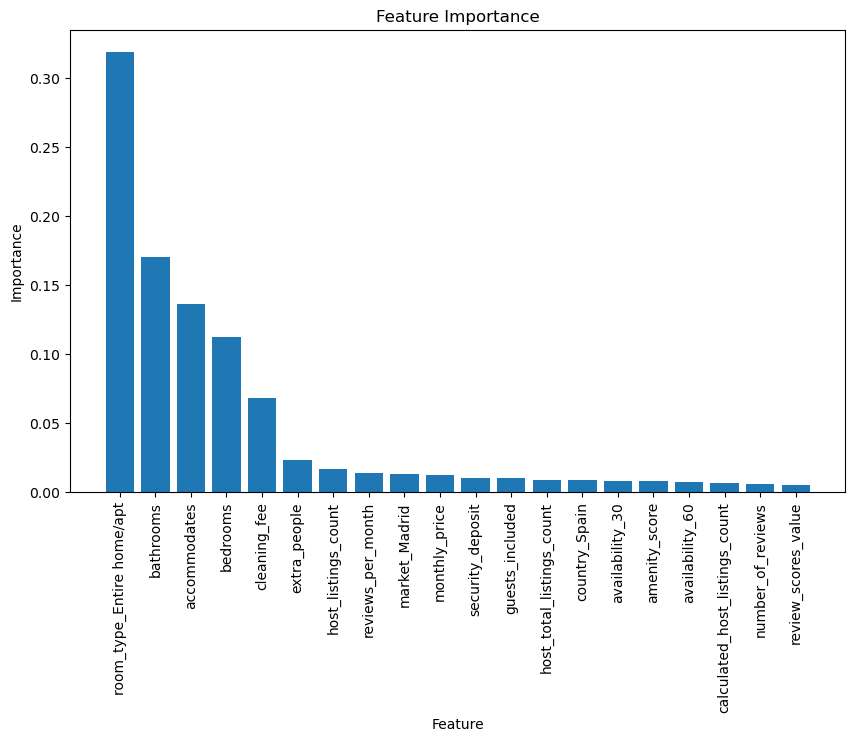

In [82]:
importances = boost.feature_importances_
feature_names = X.columns

# Ordenar las importancias y los nombres de las variables de manera descendente
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_feature_names = feature_names[indices]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances[:20])), sorted_importances[:20])
plt.xticks(range(len(importances[:20])), sorted_feature_names[:20], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

En el gráfico anterior podemos observar las características ordenadas de mayor a menor importancia. Las características más importantes son el tipo de habitación o los baños. Por la cola están características como el número de reseñas o la calificación de las mismas.

In [83]:
## Se comprueba que se obtienen los mismos resultados en el modelo GradientBoostingRegressor con datos no escaldos vs con datos escaldos
## Se obtienen resultados muy parecidos

X = df_normalized.drop('price', axis=1) 
y = df_normalized['price']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

boost = GradientBoostingRegressor()
boost.fit(X_train, y_train)

boost_pred_y = boost.predict(X_test)

score_train = boost.score(X_train, y_train)

print("Score en los datos de train:", score_train)

r2 = r2_score(y_test, boost_pred_y)
print("Coeficiente de determinación R² en los datos de test:", r2)

Score en los datos de train: 0.7264046047626499
Coeficiente de determinación R² en los datos de test: 0.6846950066939423


In [84]:
## Modelo GradientBoostingRegressor utilizando el dataframe PCA 

X = df_PCA
y = df_dummies['price']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

boost = GradientBoostingRegressor()
boost.fit(X_train, y_train)

boost_pred_y = boost.predict(X_test)

score_train_XGB_PCA = boost.score(X_train, y_train)

print("Score en los datos de train:", score_train_XGB_PCA)

mse_XGB_PCA = mean_squared_error(y_test, boost_pred_y)
print("Mean Squared Error (MSE) en los datos de test:", mse_XGB_PCA)

mae_XGB_PCA = mean_absolute_error(y_test, boost_pred_y)
print("Mean Absolute Error (MAE) en los datos de test:", mae_XGB_PCA)

r2_XGB_PCA = r2_score(y_test, boost_pred_y)
print("Coeficiente de determinación R² en los datos de test:", r2_XGB_PCA)

Score en los datos de train: 0.8363705724678817
Mean Squared Error (MSE) en los datos de test: 373.94527566406805
Mean Absolute Error (MAE) en los datos de test: 13.350113143832111
Coeficiente de determinación R² en los datos de test: 0.7819588181381321


## Linear Regression

In [85]:
from sklearn.linear_model import LinearRegression

X = df_dummies.drop('price', axis=1) 
y = df_dummies['price']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

linear_pred_y = linear_model.predict(X_test)

score_train = linear_model.score(X_train, y_train)
score_test = linear_model.score(X_test, y_test)

print("Score en los datos de train:", score_train)
print("Score en los datos de test:", score_test)

Score en los datos de train: 0.6182910240202026
Score en los datos de test: 0.5834684575918587


Observamos que el modelo tiene overfitting, al obtener un R2 negativo sobre los datos de test, por lo que usamos el método ridge y lasso para que apliquen penalizaciones L2 y L1 respectivamente y asi terminar con el overfitting

In [86]:
from sklearn.linear_model import Ridge

X = df_dummies.drop('price', axis=1) 
y = df_dummies['price']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ridge_model = Ridge(alpha=0.1)  # Ajusta el valor de alpha según tus necesidades
ridge_model.fit(X_train, y_train)

ridge_pred_y = ridge_model.predict(X_test)

score_train_linear = ridge_model.score(X_train, y_train)
print("Score en los datos de train (Ridge):", score_train_linear)
mse_linear = mean_squared_error(y_test, ridge_pred_y)
print("Mean Squared Error (MSE) en los datos de test:", mse_linear)
mae_linear = mean_absolute_error(y_test, ridge_pred_y)
print("Mean Absolute Error (MAE) en los datos de test:",mae_linear)
score_test_linear = ridge_model.score(X_test, y_test)
print("Score en los datos de test (Ridge):", score_test_linear)


Score en los datos de train (Ridge): 0.6182860152092791
Mean Squared Error (MSE) en los datos de test: 714.1048893658326
Mean Absolute Error (MAE) en los datos de test: 18.272135744075047
Score en los datos de test (Ridge): 0.5836174858094991


In [87]:
from sklearn.linear_model import Lasso

X = df_dummies.drop('price', axis=1)  
y = df_dummies['price']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lasso_model = Lasso(alpha=0.2)  
lasso_model.fit(X_train, y_train)

lasso_pred_y = lasso_model.predict(X_test)

score_train_linear = lasso_model.score(X_train, y_train)
print("Score en los datos de train (Lasso):", score_train_linear)
mse_linear = mean_squared_error(y_test, lasso_pred_y)
print("Mean Squared Error (MSE) en los datos de test:", mse_linear)
mae_linear = mean_absolute_error(y_test, lasso_pred_y)
print("Mean Absolute Error (MAE) en los datos de test:", mae_linear)
score_test_linear = lasso_model.score(X_test, y_test)
print("Score en los datos de test (Lasso):", score_test_linear)



Score en los datos de train (Lasso): 0.6054300368933488
Mean Squared Error (MSE) en los datos de test: 722.8914179117127
Mean Absolute Error (MAE) en los datos de test: 18.3596498061767
Score en los datos de test (Lasso): 0.5784942092412779


In [88]:
from sklearn.linear_model import Lasso

X = df_PCA 
y = df_dummies['price']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lasso_model = Lasso(alpha=0.2)  
lasso_model.fit(X_train, y_train)

lasso_pred_y = lasso_model.predict(X_test)

score_train_linear_PCA = lasso_model.score(X_train, y_train)
print("Score en los datos de train (Lasso):", score_train_linear_PCA)
mse_linear_PCA = mean_squared_error(y_test, lasso_pred_y)
print("Mean Squared Error (MSE) en los datos de test:", mse_linear_PCA)
mae_linear_PCA = mean_absolute_error(y_test, lasso_pred_y)
print("Mean Absolute Error (MAE) en los datos de test:", mae_linear_PCA)
score_test_linear_PCA = lasso_model.score(X_test, y_test)
print("Score en los datos de test (Lasso):", score_test_linear_PCA)


Score en los datos de train (Lasso): 0.7352010422183091
Mean Squared Error (MSE) en los datos de test: 505.46282211458515
Mean Absolute Error (MAE) en los datos de test: 15.312575108988757
Score en los datos de test (Lasso): 0.7052731554760772


In [89]:
# Visualizamos en la siguiente tabla la precisión del modelo Linear Regression sobre una muestra de 20 alojamientos en el df test
df_y_test = pd.DataFrame(y_test)
df_y_test["predicted_price"] = lasso_pred_y
df_y_test.head(20)

,price,predicted_price
11098,15.0,19.575953
8144,61.0,71.795718
6618,66.0,78.419829
181,72.0,77.964471
5826,20.0,16.926144
9459,91.0,66.830765
13607,45.0,38.297289
169,50.0,80.042466
9808,26.0,39.752478
468,30.0,26.255032


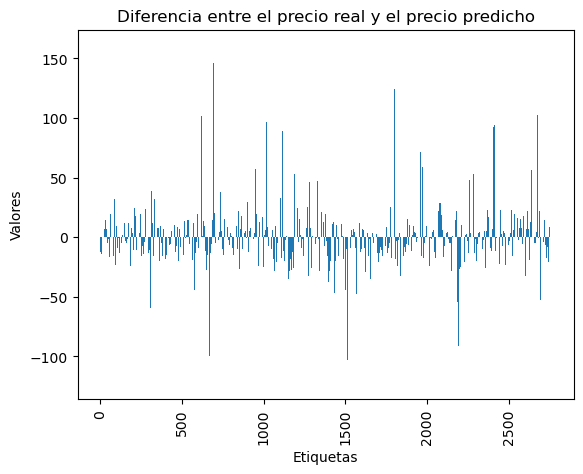

In [90]:
df_y_test["diff_price"] = df_y_test["price"] - df_y_test["predicted_price"]
df_y_test.reset_index(inplace = True)

plt.bar(df_y_test.index.values, df_y_test["diff_price"].values)

plt.xlabel('Etiquetas')
plt.ylabel('Valores')
plt.title('Diferencia entre el precio real y el precio predicho')
plt.xticks(rotation=90)
plt.show()


# Decision Tree

In [91]:
from sklearn.tree import DecisionTreeRegressor

X = df_dummies.drop('price', axis=1) 
y = df_dummies['price']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = DecisionTreeRegressor(random_state=40, max_depth=5) 
regressor.fit(X_train, y_train)

regressor_pred_y = regressor.predict(X_test)

score_train_DT = regressor.score(X_train, y_train)

print("Score en los datos de train:", score_train_DT)

mse_DT = mean_squared_error(y_test, regressor_pred_y)
print("Mean Squared Error (MSE) en los datos de test:", mse_DT)

mae_DT = mean_absolute_error(y_test, regressor_pred_y)
print("Mean Absolute Error (MAE) en los datos de test:", mae_DT)

r2_DT = r2_score(y_test, regressor_pred_y)
print("Coeficiente de determinación R² en los datos de test:", r2_DT)

Score en los datos de train: 0.6241005480848996
Mean Squared Error (MSE) en los datos de test: 722.7757220773165
Mean Absolute Error (MAE) en los datos de test: 17.871583339586476
Coeficiente de determinación R² en los datos de test: 0.57856166953055


In [92]:
# Visualizamos en la siguiente tabla la precisión del modelo de arboles de Regression sobre una muestra de 20 alojamientos en el df test
df_y_test = pd.DataFrame(y_test)
df_y_test["predicted_price"] = regressor_pred_y
df_y_test.head(20)

,price,predicted_price
11098,15.0,31.097610
8144,61.0,71.176871
6618,66.0,55.021739
181,72.0,61.585121
5826,20.0,25.025663
9459,91.0,61.585121
13607,45.0,38.992605
169,50.0,71.176871
9808,26.0,31.097610
468,30.0,25.025663


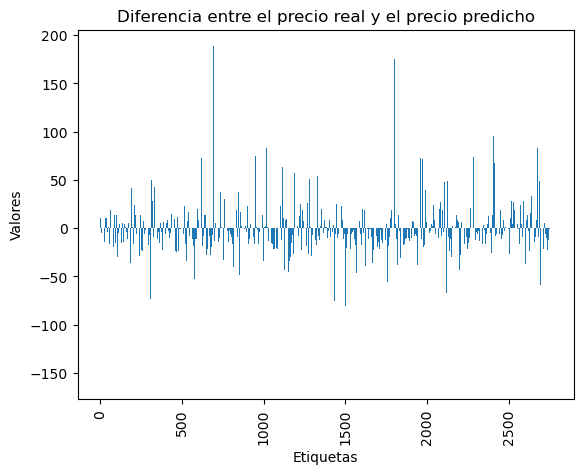

In [93]:
df_y_test["diff_price"] = df_y_test["price"] - df_y_test["predicted_price"]
df_y_test.reset_index(inplace = True)

plt.bar(df_y_test.index.values, df_y_test["diff_price"].values)

plt.xlabel('Etiquetas')
plt.ylabel('Valores')
plt.title('Diferencia entre el precio real y el precio predicho')
plt.xticks(rotation=90)
plt.show()


In [94]:
from sklearn.tree import DecisionTreeRegressor

X =  df_PCA
y = df_dummies['price']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = DecisionTreeRegressor(random_state=40, max_depth=7) 
regressor.fit(X_train, y_train)

regressor_pred_y = regressor.predict(X_test)

score_train_DT_PCA = regressor.score(X_train, y_train)

print("Score en los datos de train:", score_train_DT_PCA)

mse_DT_PCA = mean_squared_error(y_test, regressor_pred_y)
print("Mean Squared Error (MSE) en los datos de test:", mse_DT_PCA)

mae_DT_PCA = mean_absolute_error(y_test, regressor_pred_y)
print("Mean Absolute Error (MAE) en los datos de test:", mae_DT_PCA)

r2_DT_PCA = r2_score(y_test, regressor_pred_y)
print("Coeficiente de determinación R² en los datos de test:", r2_DT_PCA)

Score en los datos de train: 0.774493925846036
Mean Squared Error (MSE) en los datos de test: 567.3442484537857
Mean Absolute Error (MAE) en los datos de test: 16.268748082985418
Coeficiente de determinación R² en los datos de test: 0.6691911397042867


# Cross Validation 

In [95]:
# rrealizamos cross validation
from sklearn.model_selection import cross_val_score

regressor = DecisionTreeRegressor(random_state=40)
cross_validation_DT = cross_val_score(regressor, X, y, cv=5) 
print("Scores de validación cruzada Decision Tree:", cross_validation_DT)
print("Mean Score de validación cruzada Decision Tree:", cross_validation_DT.mean())

Scores de validación cruzada Decision Tree: [0.41541883 0.55008186 0.54857894 0.58692853 0.48745255]
Mean Score de validación cruzada Decision Tree: 0.517692144164662


In [96]:
regressor = GradientBoostingRegressor()
cross_validation_xgb = cross_val_score(regressor, X, y, cv=5) 
print("Scores de validación cruzada XGB:", cross_validation_xgb)
print("Mean Score de validación cruzada XGB:", cross_validation_xgb.mean())

Scores de validación cruzada XGB: [0.69182601 0.80819679 0.7925406  0.80344044 0.77286662]
Mean Score de validación cruzada XGB: 0.7737740910717283


In [97]:
regressor = Lasso(alpha=0.3)
cross_validatio_linear = cross_val_score(regressor, X, y, cv=5) 
print("Scores de validación cruzada Linear Regression:", cross_validatio_linear)
print("Mean Score de validación cruzada Linear Regression:", cross_validatio_linear.mean())

Scores de validación cruzada Linear Regression: [0.70290243 0.73775429 0.71473361 0.74518426 0.70634799]
Mean Score de validación cruzada Linear Regression: 0.7213845161362084


# Redes Neuronales

In [98]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

X = df_PCA
y = df_dummies['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

parametros = {
    'hidden_layer_sizes': [(100,), (100, 50), (50, 25)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.1, 0.01, 0.001],
    'learning_rate_init': [0.1, 0.01, 0.001]
}

regressor = MLPRegressor(max_iter=200, shuffle=True, random_state=42)

grid_search = GridSearchCV(regressor, parametros, cv=5)
grid_search.fit(X_train, y_train)
mejor_modelo = grid_search.best_estimator_
mejores_parametros = grid_search.best_params_
mejor_modelo.fit(X_train, y_train)
predicciones = mejor_modelo.predict(X_test)

mse = mean_squared_error(y_test, predicciones)
mae = mean_absolute_error(y_test, predicciones)
r2 = r2_score(y_test, predicciones)

print("Mean Squared Error (MSE) en los datos de test:", mse)
print("Mean Absolute Error (MAE) en los datos de test:", mae)
print("Coeficiente de determinación R² en los datos de test:", r2)
print("Mejores parámetros encontrados:", mejores_parametros)


Mean Squared Error (MSE) en los datos de test: 86.80917860262178
Mean Absolute Error (MAE) en los datos de test: 3.9930926152267143
Coeficiente de determinación R² en los datos de test: 0.9493830324093264
Mejores parámetros encontrados: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.01, 'solver': 'adam'}


In [102]:
# Utilizamos el siguiente modelo de RRNN cuyos parametros han sido optimizados utilizando GridSearchCV
# Se guarda el modelo en un pickle para crear el evaluador automatico
from sklearn.neural_network import MLPRegressor
import pickle

regressor_optimizado = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', 
                         alpha=0.001, batch_size='auto', learning_rate='constant', 
                         learning_rate_init=0.01, max_iter=200, shuffle=True, random_state=42)
regressor_optimizado.fit(X_train, y_train)
pickle.dump(regressor_optimizado, open(f"airbnb-rrnn.pickle", "wb"))



# Comparación de Modelos

In [106]:
models = ['xgb_model','xgb_model_pca','linear_model','linear_model_pca','dt_model','dt_model_pca', 'RRNN_model']
score_train = [score_train_XGB,score_train_XGB_PCA,score_train_linear,score_train_linear_PCA,score_train_DT,score_train_DT_PCA, r2_RRNN]
MSE = [mse_XGB,mse_XGB_PCA,mse_linear,mse_linear_PCA,mse_DT,mse_DT_PCA, mse_RRNN]
MAE = [mae_XGB,mae_XGB_PCA,mae_linear,mae_linear_PCA,mae_DT,mae_DT_PCA, mae_RRNN]
score_test = [r2_XGB,r2_XGB_PCA,score_test_linear,score_test_linear_PCA,r2_DT,r2_DT_PCA, mae_RRNN]

comparative_df = pd.DataFrame(
    {'Models':models, 
    'Score Train Data':score_train,
    'Mean Squared Error (MSE)':MSE,
    'Mean Absolute Error (MAE)':MAE,
    'Score Test Data':score_test
    })

comparative_df

,Models,Score Train Data,Mean Squared Error (MSE),Mean Absolute Error (MAE),Score Test Data
0,xgb_model,0.726405,540.776178,15.447828,0.684683
1,xgb_model_pca,0.836371,373.945276,13.350113,0.781959
2,linear_model,0.605430,722.891418,18.359650,0.578494
3,linear_model_pca,0.735201,505.462822,15.312575,0.705273
4,dt_model,0.624101,722.775722,17.871583,0.578562
5,dt_model_pca,0.774494,567.344248,16.268748,0.669191
6,RRNN_model,0.949383,86.809179,3.993093,3.993093


Tras estimar los distintos modelos, llegamos a la conclusión de que se obtienen mejores resultados tras hacer un PCA que con el df original. Tras comprobar esto, hemos realizado el modelo de Redes Neuronales directamente con el df_PCA y hemos visto que es con el modelo que mejor resultados obtenemos.

## Evaluador automatico

Creamos un evaluador automatico con el modelo ya entrenado de redes neuronales ya que como comentamos anteriormente es el modelo con mejores resultados.

In [131]:
# Funcion que transforma el dataframe 
def transform_df(df, X_test): 
    def sentiment_polarity(text):
        try:
            blob = TextBlob(text).sentiment.polarity
            return blob
        except: 
            pass

    def split_geolocalization(df):
        df[['latitud', 'longitud']] = df['geolocation'].str.split(',', expand=True)
        df['latitud'] = pd.to_numeric(df['latitud'])
        df['longitud'] = pd.to_numeric(df['longitud'])
        return df

    def convert_to_days(value):
        try: 
            if value == 'today':
                return 0
            elif value == 'yesterday':
                return 1
            elif value == 'never':
                return None
            else:
                num = int(re.search(r'\d+', value).group())
                if 'day' in value:
                    return num
                elif 'week' in value:
                    return num * 7
                elif 'month' in value:
                    return num * 30

        except: 
            return 0

    def score_amenities(amenities_str):
        try:
            importance = {
                'TV': 3,
                'Cable TV': 1,
                'Internet': 8,
                'Wireless Internet': 7,
                'Air conditioning': 5,
                'Pool': 8,
                'Free parking on premises': 7,
                'Heating': 6,
                'Family/kid friendly': 5,
                'Smoke detector': 6,
                'Carbon monoxide detector': 2,
                'Fire extinguisher': 3,
                'Essentials': 4,
                'Shampoo': 1,
                'Lock on bedroom door':2,
                '24-hour check-in': 7,
                'Hangers': 3,
                'Hair dryer': 4,
                'Iron': 5,
                'Laptop friendly workspace': 7,
                'Self Check-In': 7,
                'Doorman Entry': 8,
                'Private entrance': 8,
                'Elevator in building': 8,
                'Washer': 7,
                'Wheelchair accessible': 6,
                'Kitchen': 8,
                'Doorman': 9,
                'Breakfast': 10,
                'Buzzer/wireless intercom': 3,
                'Lockbox': 4
            }
            # Separar las amenities en una lista
            amenities_list = amenities_str.split(',')
            # Sumar los valores de importancia de cada amenity
            score = sum([importance.get(a.strip(), 0) for a in amenities_list])
            return score
        except: 
            pass

    def calc_smooth_mean(df, by, on, m):
        mean = df[on].mean()
        agg = df.groupby(by)[on].agg(['count', 'mean'])
        counts = agg['count']
        means = agg['mean']
        smooth = (counts * means + m * mean) / (counts + m)
        return df[by].map(smooth)

    df.drop(['has_availability', 'host_acceptance_rate', 'jurisdiction_names', 'license', 'square_feet', 
            'id', 'listing_url', 'scrape_id', 'last_scraped', 'thumbnail_url', 'medium_url', 
            'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'name',
            'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'calendar_last_scraped', 
            'host_location', 'host_verifications', 'interaction', 'notes',
            'neighborhood_overview', 'access', 'transit', 
            'street', 'neighbourhood_cleansed', 'zipcode', 'smart_location', 'city'], axis = 1, inplace = True)

    sustituir_por_0 = ['security_deposit', 'cleaning_fee', 'bedrooms', 'bathrooms', 'beds', 'reviews_per_month', 'calculated_host_listings_count', 'host_listings_count', 'host_total_listings_count']
    df.loc[:, sustituir_por_0] = df.loc[:, sustituir_por_0].fillna(0)
    sustituir_por_99 = ['monthly_price', 'weekly_price']
    df.loc[:, sustituir_por_99] = df.loc[:, sustituir_por_99].fillna(-99)

    reemplazo = {'within an hour': 1, 'within a few hours': 12, 'within a day': 24, 'a few days or more': 72}
    df['host_response_time'] = df['host_response_time'].replace(reemplazo).fillna(99)

    columns_polarity = ["summary", "house_rules", "features", "space", "host_about", "description"]
    for i in columns_polarity: 
        df[i+'_polarity'] = df[i].apply(lambda x: sentiment_polarity(x)).fillna(99)
    df.drop(columns_polarity, axis = 1, inplace = True)
    df = split_geolocalization(df)
    df.drop(['geolocation'], axis = 1, inplace = True)
    df['calendar_updated'] = df['calendar_updated'].apply(convert_to_days)
    df['calendar_updated'] = df['calendar_updated'].fillna(0)
    df['amenity_score'] = df['amenities'].apply(score_amenities).fillna(0)
    df['amenity_score'].head(5)
    df.drop(['amenities'], axis = 1, inplace = True)
    categorical = ['neighbourhood', 'neighbourhood_group_cleansed', 'country_code']
    for c in categorical:
        df[c] = calc_smooth_mean(df, by=c, on='price', m=300).fillna(999)
    cols_knn = ['review_scores_value', 'review_scores_location', 'review_scores_checkin', 'review_scores_accuracy', 'review_scores_communication', 'review_scores_cleanliness', 'review_scores_rating', 'host_response_rate']
    imputer = KNNImputer(n_neighbors=2, weights="uniform")
    model = imputer.fit(df[cols_knn])

    df_knn = pd.DataFrame(model.transform(df[cols_knn]), 
                        columns=[i for i in list(set(cols_knn))],index=df.index)
    df.drop(cols_knn, axis = 1, inplace = True)  
    df = pd.merge(df, df_knn, left_index=True, right_index=True)
    df.state = df.state.fillna('Desconocido')
    df.country = df.country.fillna('Desconocido')
    df.market = df.market.fillna('Desconocido')

    df = df[['experiences_offered', 'host_since', 'host_listings_count',
    'host_total_listings_count',
    'market', 'country', 'property_type', 'room_type',
    'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
    'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included',
    'extra_people', 'availability_30', 'availability_60',
    'availability_365', 'number_of_reviews', 'first_review', 'last_review',
    'cancellation_policy', 'calculated_host_listings_count',
    'reviews_per_month', 'amenity_score', 'review_scores_checkin']]
    df = pd.get_dummies(df)
    columnas_faltantes = set(X_test.columns) - set(df.columns)
    df = df.reindex(columns=df.columns.tolist() + list(columnas_faltantes), fill_value=0)
    df = df[list(X_test.columns)]

    return df

In [132]:
# Cogemos los 17 alojamientos que no tienen precio para intentar predecirlo
data = pd.read_csv('airbnb_listings_extract.csv', sep = ";")
data.columns = data.columns.str.lower()
data = data.rename(columns=lambda x: x.replace(' ', '_'))
data = data[data['price'].isnull()]
data.head(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_communication,review_scores_location,review_scores_value,license,jurisdiction_names,cancellation_policy,calculated_host_listings_count,reviews_per_month,geolocation,features
1337,3955511,https://www.airbnb.com/rooms/3955511,20170315084710,2017-03-15,Es Talaiot,Finca situada en centro de la isla de Mallorca...,Rodeada por un paisaje de ensueño de campos y ...,Rodeada por un paisaje de ensueño de campos y ...,none,Pina es una pequeña localidad de 400 habitante...,...,NaN,NaN,NaN,NaN,NaN,moderate,3.0,NaN,"39.5960565717,2.92568968608","Host Has Profile Pic,Requires License"
1512,13636816,https://www.airbnb.com/rooms/13636816,20170615002708,2017-06-15,Central and new! Danish design,- Super central apartment by Strøget - 2 bedro...,"The shower tap is the same as the sink tap, as...",- Super central apartment by Strøget - 2 bedro...,none,It is located by the main shopping and tourist...,...,9.0,10.0,9.0,NaN,NaN,strict,1.0,5.37,"55.6771862556,12.5736124985","Host Has Profile Pic,Host Identity Verified,In..."
1691,16199273,https://www.airbnb.com/rooms/16199273,20170407214119,2017-04-08,"Private Room in Rios Rosas, Madrid","My place is close to El Corte Ingles, Nuevos M...",NaN,"My place is close to El Corte Ingles, Nuevos M...",none,The neighborhood is really good. Quiet and cal...,...,NaN,NaN,NaN,NaN,NaN,moderate,1.0,NaN,"40.4412509377,-3.6976986412","Host Has Profile Pic,Is Location Exact,Require..."
2906,3760176,https://www.airbnb.com/rooms/3760176,20170615002708,2017-06-15,87 m2 in the heart of Vesterbro,Stay in one of the most vibrant and creative a...,"INSIDE: The apartment is perfect for 2 people,...",Stay in one of the most vibrant and creative a...,none,OUTSIDE: Vesterbro is kind of Copenhagen’s equ...,...,10.0,9.0,10.0,NaN,NaN,moderate,1.0,0.14,"55.6703787963,12.556125886","Host Has Profile Pic,Is Location Exact"
2911,820869,https://www.airbnb.com/rooms/820869,20170615002708,2017-06-15,Beauty & charm in the heart of Cph.,NaN,A spatious and beautiful apartment in an elega...,A spatious and beautiful apartment in an elega...,none,NaN,...,10.0,10.0,10.0,NaN,NaN,moderate,1.0,0.64,"55.6845581553,12.5697019142","Host Is Superhost,Host Has Profile Pic,Host Id..."


In [133]:
data = transform_df(data, X_test)
data

,index,host_since,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,monthly_price,security_deposit,...,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_flexible_new,cancellation_policy_moderate,cancellation_policy_moderate_new,cancellation_policy_strict,cancellation_policy_strict_new,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
1337,0,0,3.0,3.0,12,7.0,8.0,8.0,-99.0,0.0,...,0,1,0,0,1,0,0,0,0,0
1512,0,0,1.0,1.0,7,1.0,2.0,4.0,-99.0,0.0,...,0,1,0,0,0,0,1,0,0,0
1691,0,0,1.0,1.0,1,1.0,1.0,1.0,-99.0,100.0,...,0,1,0,0,1,0,0,0,0,0
2906,0,0,1.0,1.0,4,1.0,1.0,2.0,20000.0,0.0,...,0,1,0,0,1,0,0,0,0,0
2911,0,0,1.0,1.0,5,1.0,3.0,5.0,-99.0,0.0,...,0,1,0,0,1,0,0,0,0,0
4524,0,0,11.0,11.0,16,5.0,7.0,15.0,-99.0,0.0,...,0,1,0,0,0,0,1,0,0,0
5369,0,0,1.0,1.0,5,1.0,2.0,2.0,-99.0,0.0,...,0,1,0,0,1,0,0,0,0,0
6410,0,0,1.0,1.0,4,1.0,1.0,2.0,-99.0,0.0,...,0,1,1,0,0,0,0,0,0,0
9124,0,0,1.0,1.0,6,2.0,2.0,3.0,-99.0,0.0,...,0,1,1,0,0,0,0,0,0,0
9251,0,0,14.0,14.0,4,1.0,1.0,1.0,-99.0,0.0,...,0,1,0,0,0,0,1,0,0,0


In [134]:
# cargamos el picke del modelo
with open("airbnb-rrnn.pickle", 'rb') as handle:
    airbnb_model = pickle.load(handle)

predicted_price = airbnb_model.predict(data)


In [135]:
# El evaluador automatico predice estos precios para los 17 registros sin dato en la columna price
predicted_price

array([212.6090487 , 259.57192624,   8.46975847, 961.24748355,
        80.87106201, 321.45812839, 105.37703101,  74.93968541,
       101.04913226,  49.96591452, 104.81170854, 131.55713993,
       195.09955851, 131.44671508,  55.1014745 ,  93.55490881,
        91.49617462])